# Telecom Churn Prediction

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#! pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score,balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 500)


Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [ ]:
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("/content/train.csv")
unseen = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample.csv")
data_dict = pd.read_csv("/content/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


### Data understanding

1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [ ]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [ ]:
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [ ]:
unseen.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   65.330   64.445        31.78        20.23        23.11         60.16   
1  515.568  360.868        75.51        41.21        19.84        474.34   
2  434.884  746.239         7.54         7.86         8.40         16.98   
3  171.390   24.400         5.31         2.16         0.00         40.04   
4  406.289  413.329       450.93       609.03       700.68         60.94   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         32.16         34.83           0.00           0.00           0.00   
1        621.84        394.94           0.00           0.00           0.00   
2         45.81         45.04          22.81         103.38          26.08   
3        205.01         24.01           0.00           0.00           0.00   
4         23.84         74.16           0.00           0.00           0.00   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00           0.00           0.00             24.88   
1           0.00           0.00           0.00             75.51   
2          24.53          53.68          54.44              0.00   
3           0.00           0.00           0.00              5.31   
4           0.00           0.00           0.00              0.45   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             20.23             21.06             18.13             10.89   
1             41.21             19.84            473.61            598.08   
2              0.00              0.00              0.00              0.00   
3              0.00              0.00              2.94             98.61   
4              0.78             14.56              2.39              2.66   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              8.36              0.00             13.58              0.00   
1            377.26              0.73              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             20.51              0.00              0.00              2.35   
4             10.94              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0              0.00              0.03         43.01   
1               0.0              0.00              0.00        549.86   
2               0.0              0.00              0.00          0.00   
3               0.0              6.18              0.00          8.26   
4               0.0              0.00              0.00          2.84   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         44.71         29.43              6.90              0.00   
1        639.29        397.11              0.00              0.00   
2          0.00          0.00              0.00              0.00   
3         98.61         22.86              0.00              2.16   
4          3.44         25.51            450.48            608.24   

 

In [ ]:
data.describe(include="all")

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   69999.000000    69999.0         69297.0         69297.0   
unique           NaN        NaN             NaN             NaN   
top              NaN        NaN             NaN             NaN   
freq             NaN        NaN             NaN             NaN   
mean    34999.000000      109.0             0.0             0.0   
std     20207.115084        0.0             0.0             0.0   
min         0.000000      109.0             0.0             0.0   
25%     17499.500000      109.0             0.0             0.0   
50%     34999.000000      109.0             0.0             0.0   
75%     52498.500000      109.0             0.0             0.0   
max     69998.000000      109.0             0.0             0.0   

        loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
count          69297.0                69999                69600   
unique             NaN                    1                    1   
top                NaN            6/30/2014            7/31/2014   
freq               NaN                69999                69600   
mean               0.0                  NaN                  NaN   
std                0.0                  NaN                  NaN   
min                0.0                  NaN                  NaN   
25%                0.0                  NaN                  NaN   
50%                0.0                  NaN                  NaN   
75%                0.0                  NaN                  NaN   
max                0.0                  NaN                  NaN   

       last_date_of_month_8        arpu_6        arpu_7        arpu_8  \
count                 69266  69999.000000  69999.000000  69999.000000   
unique                    1           NaN           NaN           NaN   
top               8/31/2014           NaN           NaN           NaN   
freq                  69266           NaN           NaN           NaN   
mean                    NaN    283.134365    278.185912    278.858826   
std                     NaN    334.213918    344.366927    351.924315   
min                     NaN  -2258.709000  -1289.715000   -945.808000   
25%                     NaN     93.581000     86.714000     84.095000   
50%                     NaN    197.484000    191.588000    192.234000   
75%                     NaN    370.791000    365.369500    369.909000   
max                     NaN  27731.088000  35145.834000  33543.624000   

         onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count   67231.000000  67312.000000  66296.000000  67231.000000  67312.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      133.153275    133.894438    132.978257    198.874771    197.153383   
std       299.963093    311.277193    311.896596    316.818355    322.482226   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         7.410000      6.675000      6.410000     34.860000     32.240000   
50%        34.110000     32.280000     32.100000     96.480000     91.885000   
75%       119.390000    115.837500    115.060000    232.990000    227.630000   
max      7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

        offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count   66296.000000   67231.000000   67312.000000   66296.000000   
unique           NaN            NaN            NaN            NaN   
top              NaN            NaN            NaN            NaN   
freq             NaN            NaN            NaN            NaN   
mean      196.543577       9.765435       7.014568       7.004892   
std       324.089234      57.374429      55.960985      53.408135   
min         0.000000       0.000000       0.000000       0.000000   
25%   

In [ ]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

#### Taking the below

In [ ]:
ids = ['id']

total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
onnet = [i for i in list(data.columns) if re.search('onnet_',i)]
average_revenue = [i for i in list(data.columns) if re.search('arpu_',i)]
total_rech_num = [i for i in list(data.columns) if re.search('total_rech_num',i)]
total_rech_data = [i for i in list(data.columns) if re.search('total_rech_data',i)]
last_day_rch_amt = [i for i in list(data.columns) if re.search('last_day_rch_amt',i)]
night_pck_user = [i for i in list(data.columns) if re.search('night_pck_user',i)]
volume_based_cost = [i for i in list(data.columns) if re.search('vbc',i)]
max_rech_amt = [i for i in list(data.columns) if re.search('max_rech_amt',i)]
max_rech_data = [i for i in list(data.columns) if re.search('max_rech_data',i)]
av_rech_amt_data = [i for i in list(data.columns) if re.search('av_rech_amt_data',i)]


#Storing them in a single flat list
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             *total_incoming_minutes,
             *onnet,
             *average_revenue,
             *total_rech_num,
             *total_rech_data,
             *last_day_rch_amt,
             *night_pck_user,
             *volume_based_cost,
             *max_rech_amt,
             *max_rech_data,
             *av_rech_amt_data,
             'churn_probability']

data_tel_details = data[variables].set_index('id')

In [ ]:
data_tel_details.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
id                                                                         
0                 77                65                10           81.21   
1                  0               145                50            0.00   
2                 70               120                 0           56.49   
3                160               240               130           76.03   
4                290               136               122           63.26   

    total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
id                                                                             
0           221.68            3.63         32.24         96.68          2.33   
1            30.73           31.66          0.00         25.99         30.89   
2            99.36            0.00         53.99         82.05          0.00   
3            95.98           53.84         68.76         78.48         50.23   
4            42.94           15.76         56.99         38.11          9.63   

    arpu_3g_6  arpu_3g_7  arpu_3g_8  arpu_2g_6  arpu_2g_7  arpu_2g_8  \
id                                                                     
0         NaN        NaN        NaN        NaN        NaN        NaN   
1         NaN     122.07        NaN        NaN     122.08        NaN   
2         NaN        NaN        NaN        NaN        NaN        NaN   
3         NaN        NaN        NaN        NaN        NaN        NaN   
4         0.0      35.00        0.0        0.0      35.12        0.0   

    vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  vol_2g_mb_7  \
id                                                                    
0           0.0         0.00          0.0          0.0         0.00   
1           0.0         3.96          0.0          0.0       352.91   
2           0.0         0.00          0.0          0.0         0.00   
3           0.0         0.00          0.0          0.0         0.00   
4           0.0         0.00          0.0        390.8       308.89   

    vol_2g_mb_8   aon  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
id                                                                      
0          0.00  1958           11.84           53.04           40.56   
1          0.00   710            3.44           39.44           25.04   
2          0.00   882          124.29           33.83           36.64   
3          0.00   982           95.11           50.18           83.84   
4        213.47   647           21.54            9.36           28.31   

    onnet_mou_6  onnet_mou_7  onnet_mou_8   arpu_6   arpu_7   arpu_8  \
id                                                                     
0         48.58       124.38         1.29   31.277   87.009    7.527   
1          0.00         0.00         0.00    0.000  122.787   42.953   
2          0.53        15.93         0.00   60.806  103.176    0.000   
3          7.26        16.01         0.00  156.362  205.260  111.095   
4         21.28         4.83         6.13  240.708  128.191  101.565   

    arpu_3g_6  arpu_3g_7  arpu_3g_8  arpu_2g_6  arpu_2g_7  arpu_2g_8  \
id                                                                     
0         NaN        NaN        NaN        NaN        NaN        NaN   
1         NaN     122.07        NaN        NaN     122.08        NaN   
2         NaN        NaN        NaN        NaN        NaN        NaN   
3         NaN        NaN        NaN        NaN        NaN        NaN   
4         0.0      35.00        0.0        0.0      35.12        0.0   

    total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_data_6  \
id                                                                            
0                  3                 2                 2                NaN   
1                  3                 4                 5                NaN   
2                  2                 4                 2             

# 2. Data cleaning

### Handling missing data

- Checking the missing data using missingo library

<Axes: >

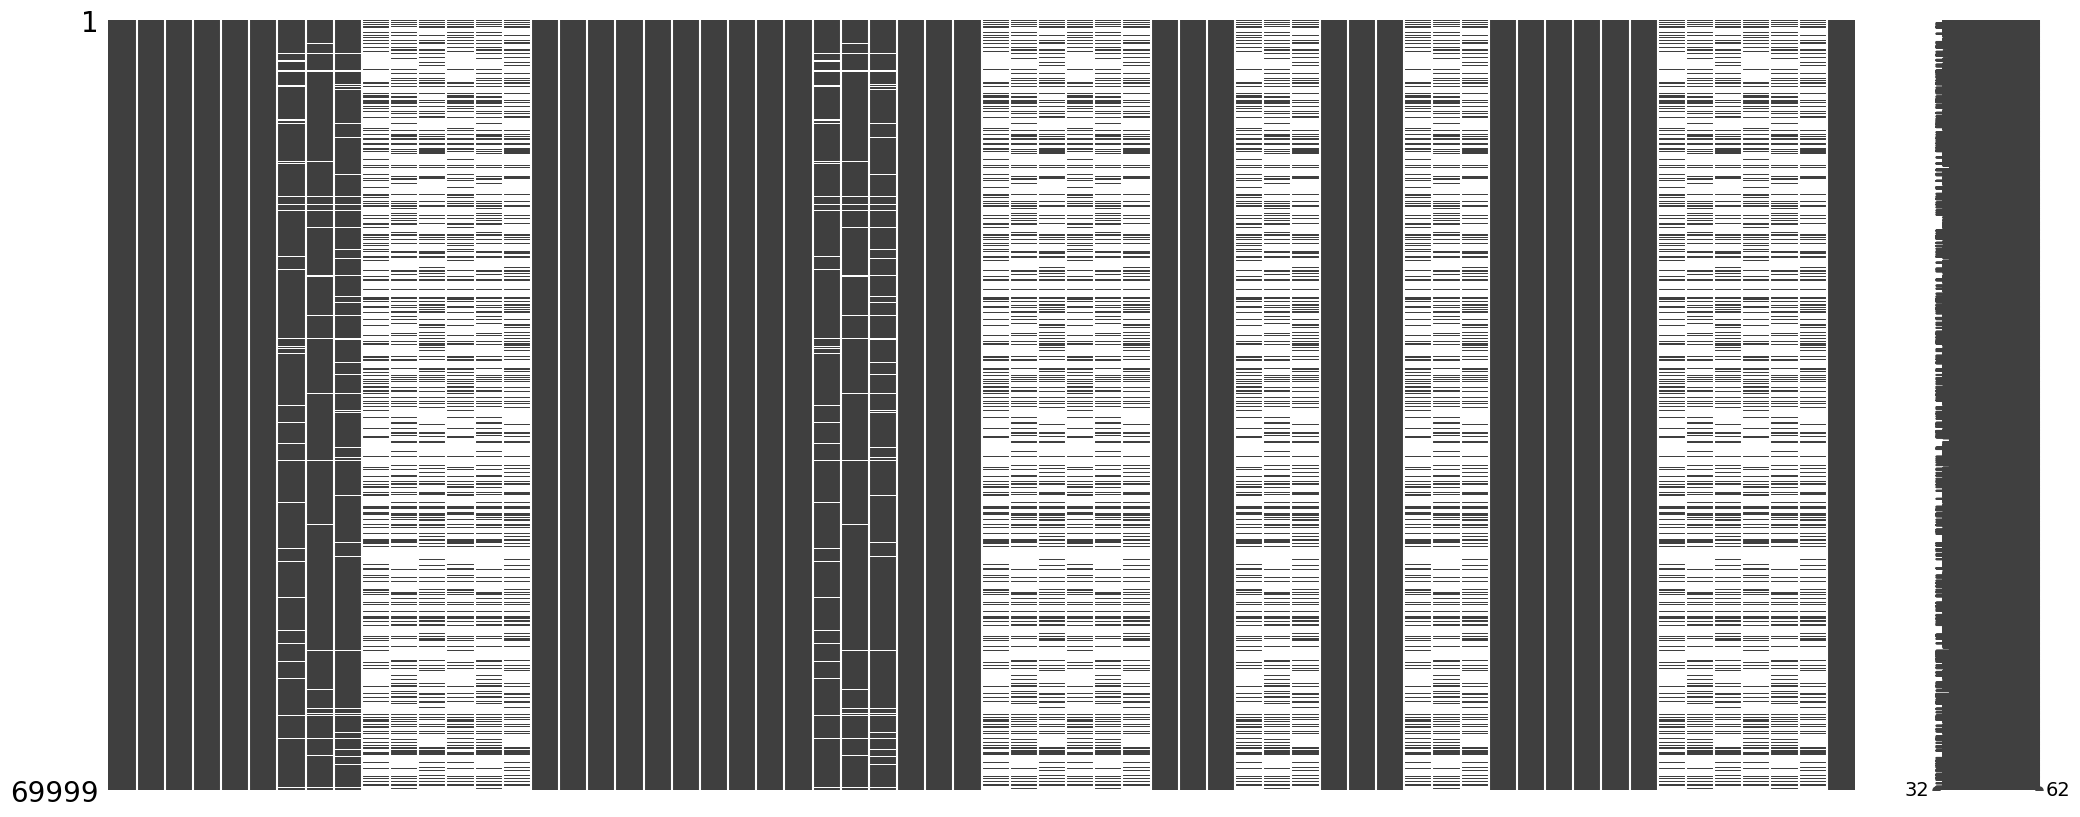

In [ ]:
msno.matrix(data_tel_details)

<Axes: >

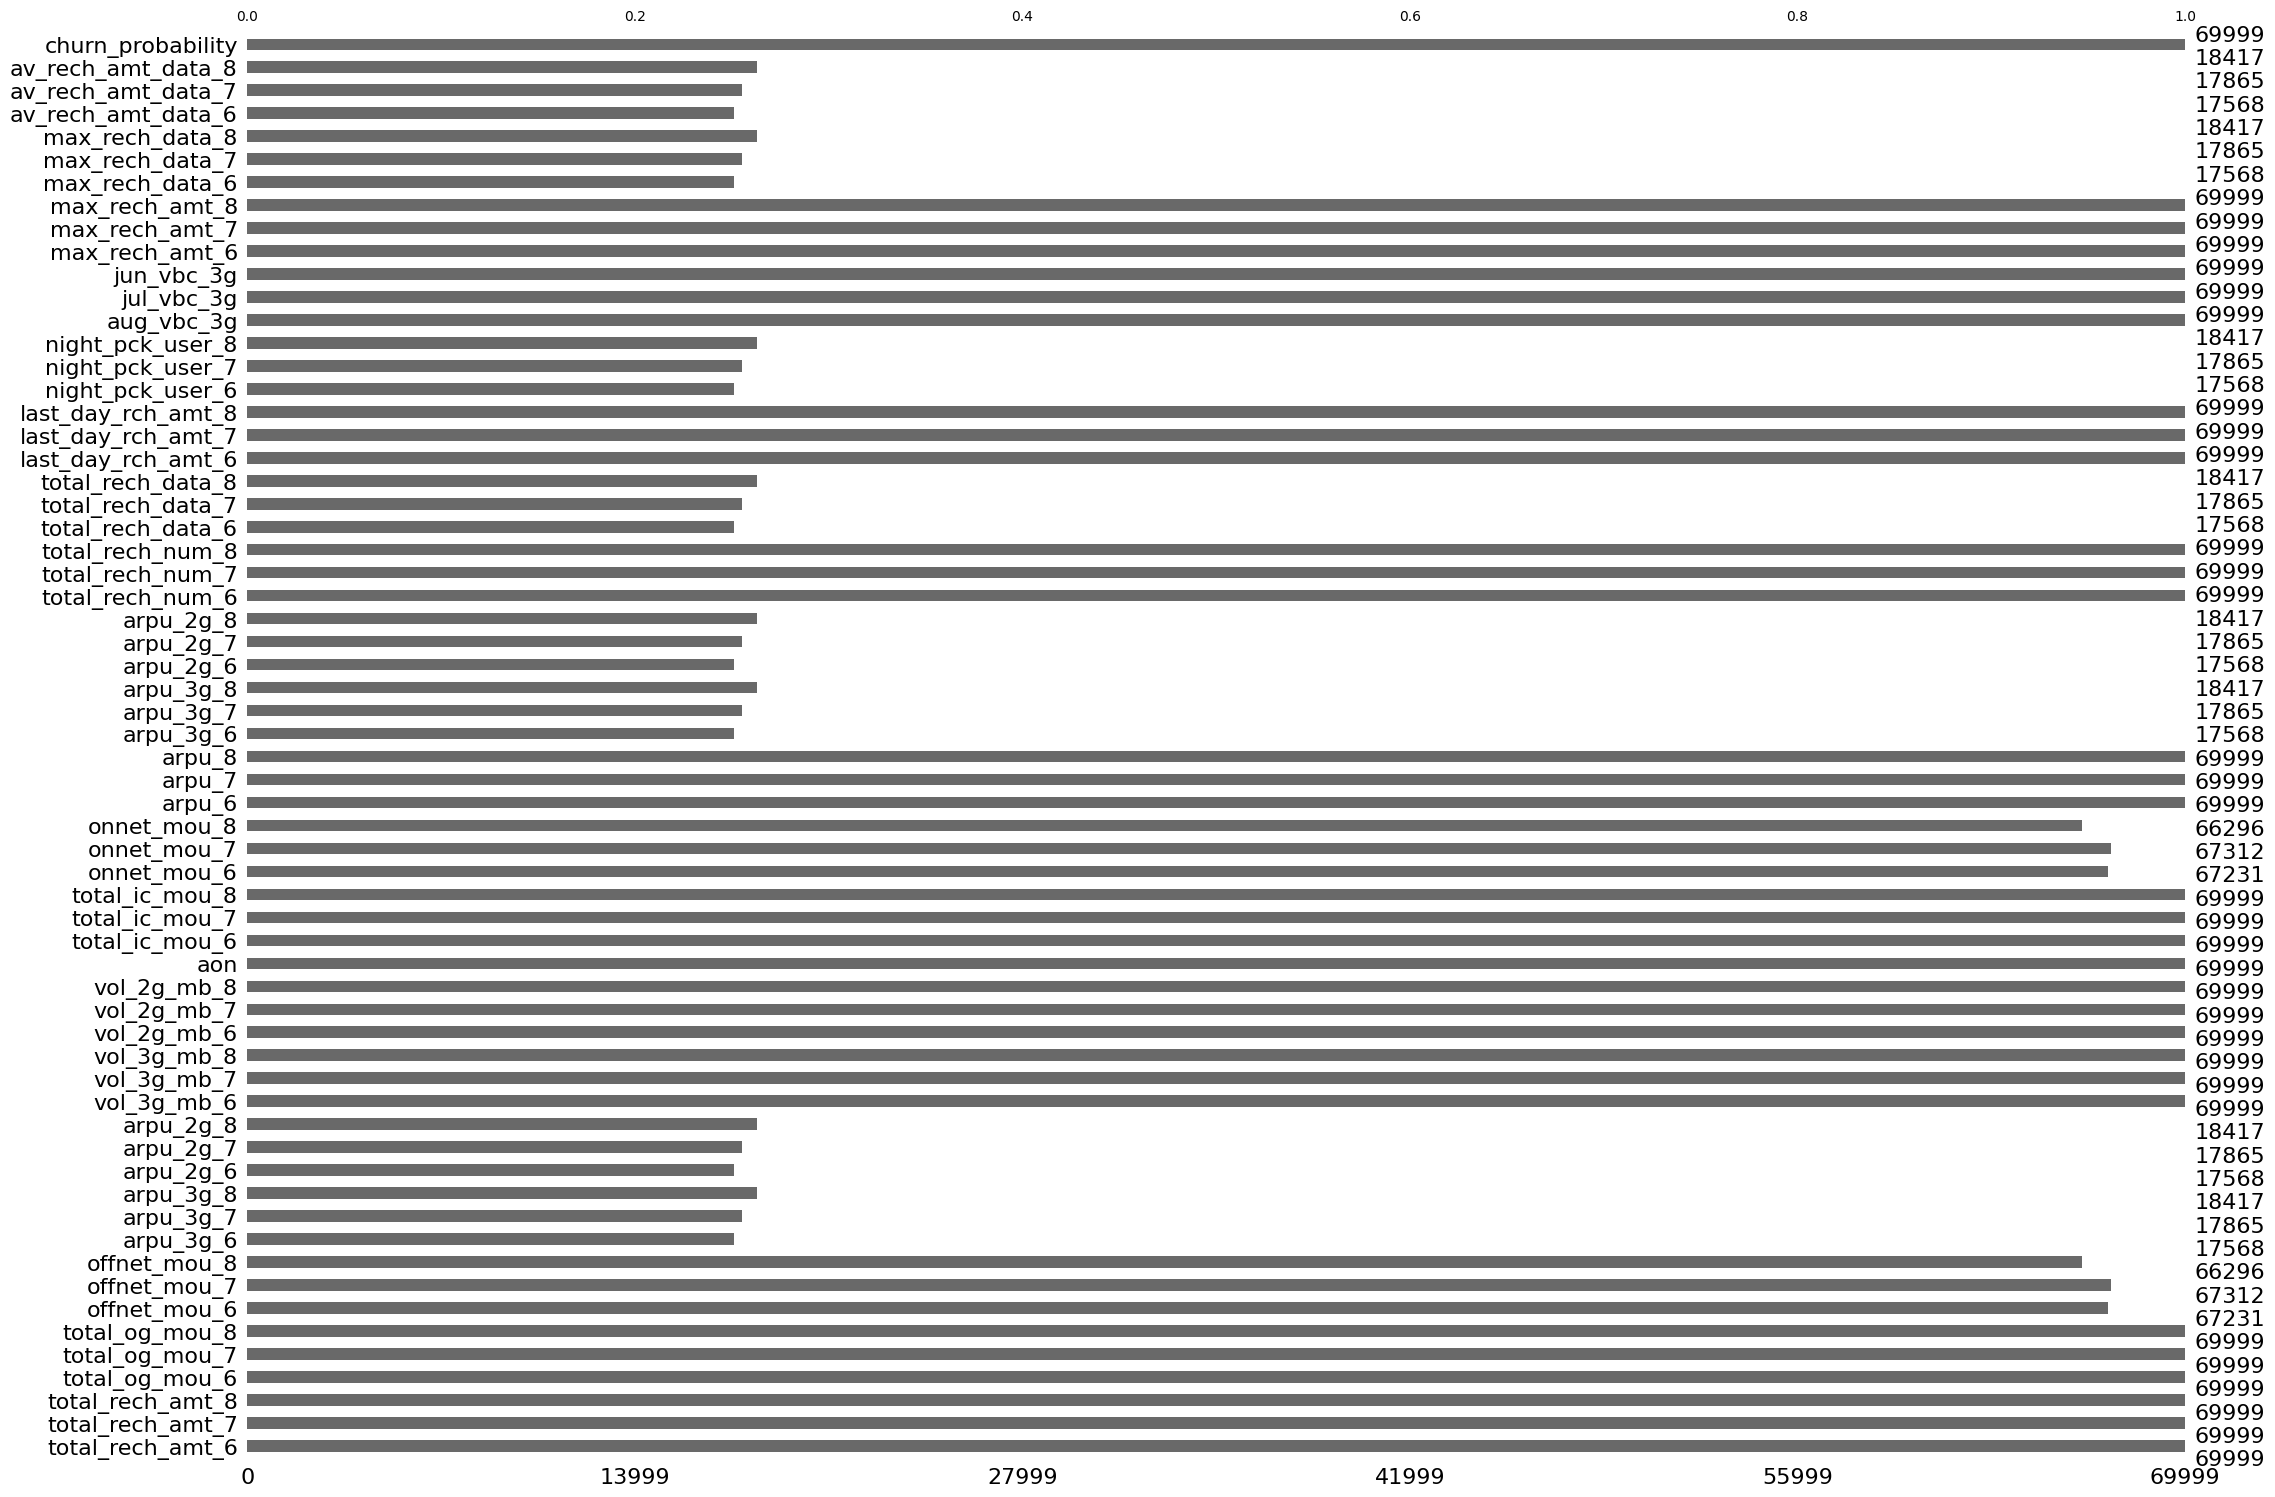

In [ ]:
msno.bar(data_tel_details)

#### Observation : 
- There are many columns which has more than 60% values missing or contains the null values as per the above chart

<Axes: >

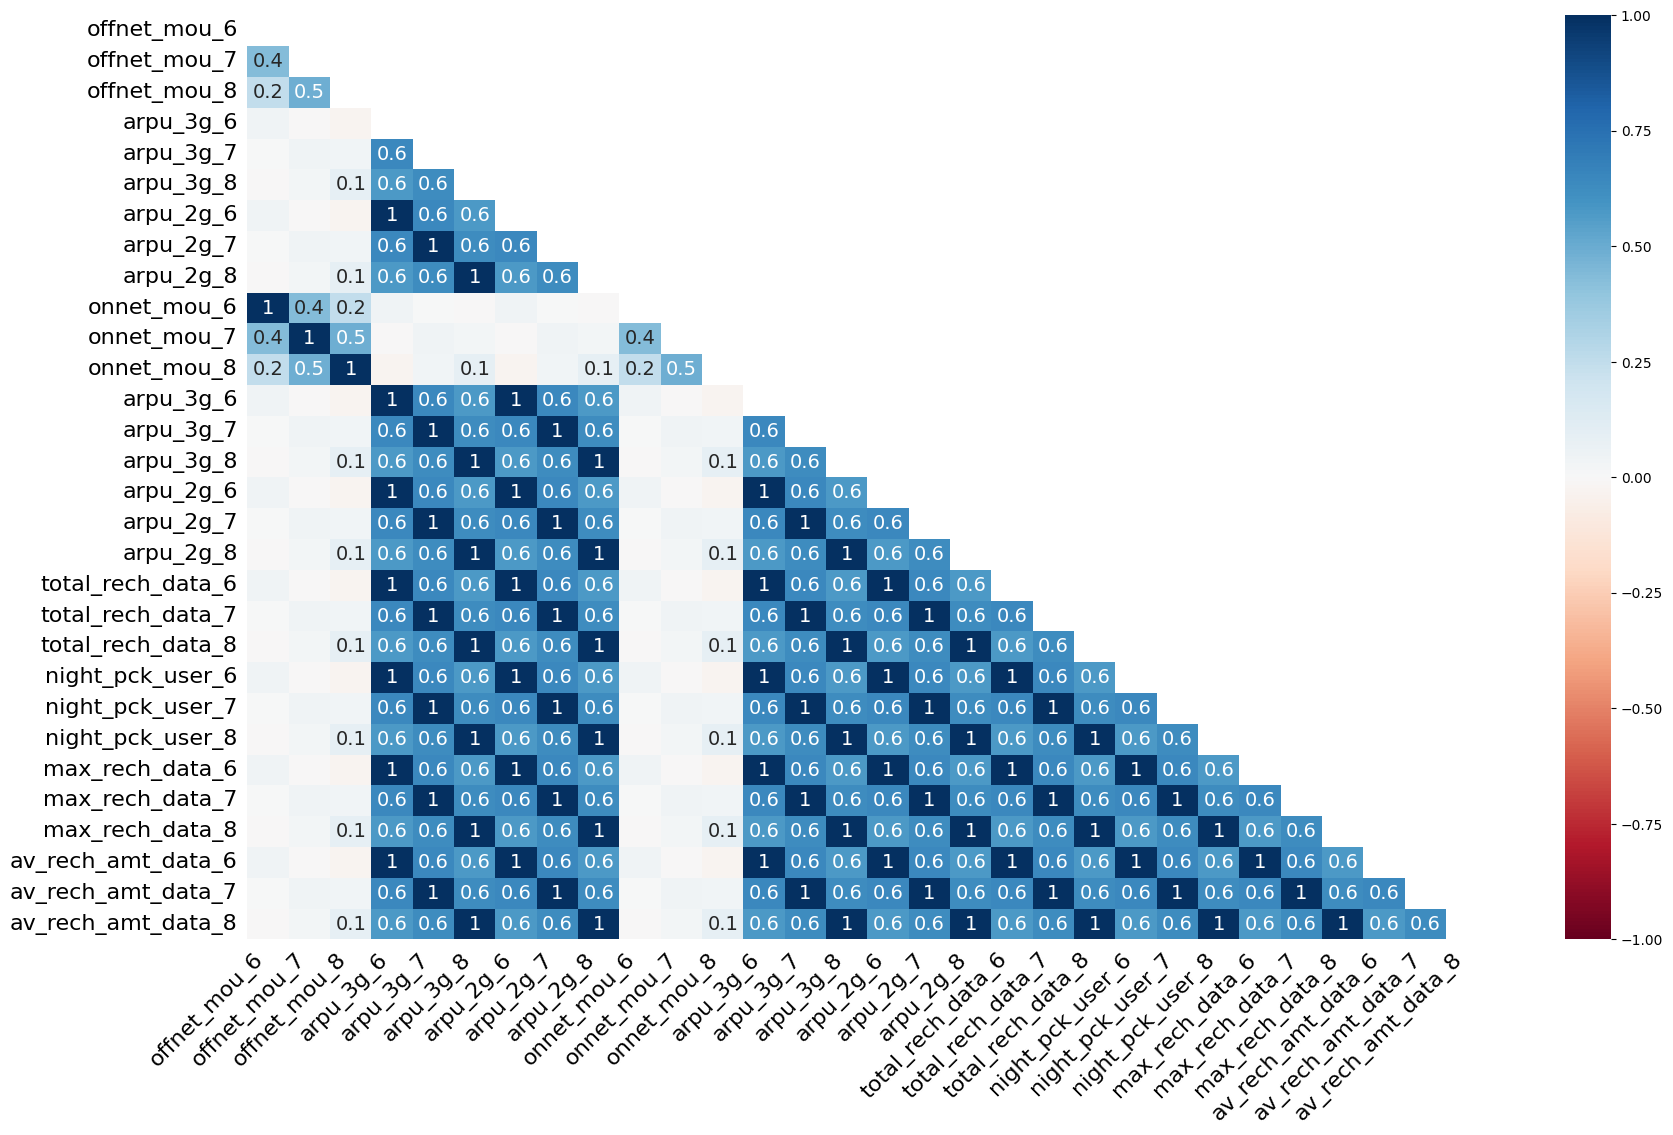

In [ ]:
msno.heatmap(data_tel_details)

In [ ]:
# Checking the null value percentage to identify the null values
nullDF = pd.DataFrame({"Null%":round(data_tel_details.isnull().sum()*100/len(data_tel_details),2)})
nullDF.loc[nullDF["Null%"] > 1].sort_values(by=["Null%"],ascending=False)

Null%
arpu_2g_6           74.90
arpu_2g_6           74.90
night_pck_user_6    74.90
arpu_3g_6           74.90
max_rech_data_6     74.90
total_rech_data_6   74.90
av_rech_amt_data_6  74.90
arpu_3g_6           74.90
arpu_2g_7           74.48
total_rech_data_7   74.48
arpu_3g_7           74.48
arpu_3g_7           74.48
night_pck_user_7    74.48
av_rech_amt_data_7  74.48
arpu_2g_7           74.48
max_rech_data_7     74.48
max_rech_data_8     73.69
night_pck_user_8    73.69
total_rech_data_8   73.69
av_rech_amt_data_8  73.69
arpu_2g_8           73.69
arpu_3g_8           73.69
arpu_2g_8           73.69
arpu_3g_8           73.69
onnet_mou_8          5.29
offnet_mou_8         5.29
onnet_mou_6          3.95
offnet_mou_6         3.95
offnet_mou_7         3.84
onnet_mou_7          3.84

#### Observation
- There are multiple columns which has the missing % more than 40. Hence dropping all of these.

In [ ]:
# Dropping the variables with more 40% missing values
drop_list = nullDF.loc[nullDF["Null%"] > 40].index.values.tolist()

In [ ]:
# Creating the list for dropping columns
drop_list

['arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [ ]:
data_tel_details.shape

(69999, 62)

In [ ]:
# Dropping the above list from the source
data_tel_details.drop(drop_list, axis=1, inplace=True)

In [ ]:
data_tel_details.shape

(69999, 38)

<Axes: >

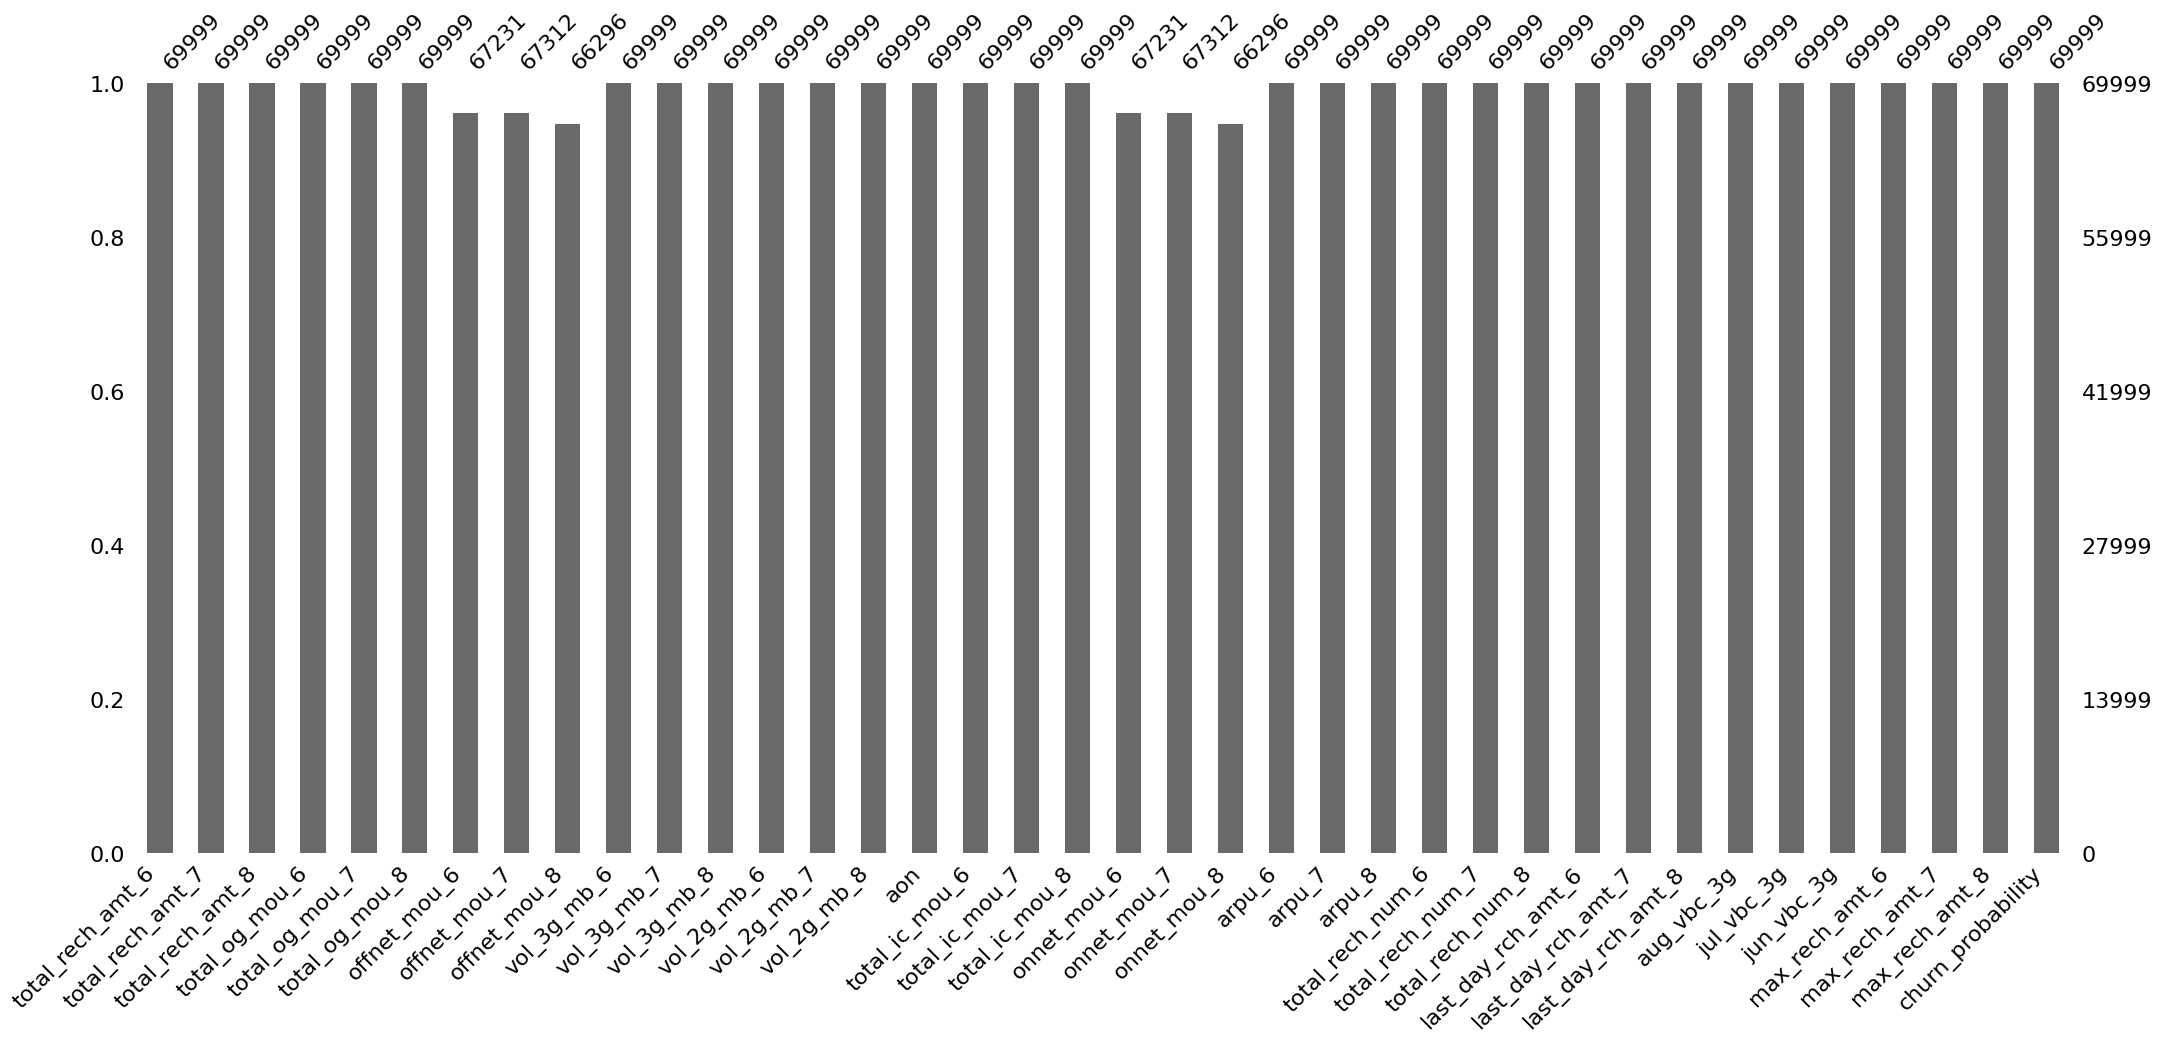

In [ ]:
msno.bar(data_tel_details)

#### Observation
- Removed all the columns which has null values more than 40%. There are some of the columns which has missing values. 
- We need to impute the values.

In [ ]:
# Checking null values again to verify the remaining variables
nullDF = pd.DataFrame({"Null%":round(data_tel_details.isnull().sum()*100/len(data_tel_details),2)})
nullDF.loc[nullDF["Null%"] > 1].sort_values(by=["Null%"],ascending=False)

Null%
offnet_mou_8   5.29
onnet_mou_8    5.29
offnet_mou_6   3.95
onnet_mou_6    3.95
offnet_mou_7   3.84
onnet_mou_7    3.84

##### Observation : 
- offnet_mou columns has 3-6% missing values

In [ ]:
# Checking the type of values to impute
impute_list = nullDF.loc[nullDF["Null%"] > 1].index.values.tolist()

for col in impute_list:
    print("\n", col)
    print(data_tel_details[col].value_counts())
    print("\n", "Null values for " + col)
    print(data_tel_details[col].isnull().sum())


 offnet_mou_6
0.00       2570
1.01         32
0.01         30
0.58         25
0.63         24
           ... 
134.03        1
317.68        1
368.33        1
1586.21       1
575.46        1
Name: offnet_mou_6, Length: 26254, dtype: int64

 Null values for offnet_mou_6
2768

 offnet_mou_7
0.00       2647
0.53         24
0.33         24
0.28         24
0.13         23
           ... 
242.74        1
1540.93       1
135.38        1
1165.94       1
236.61        1
Name: offnet_mou_7, Length: 26139, dtype: int64

 Null values for offnet_mou_7
2687

 offnet_mou_8
0.00      2961
0.03        31
1.01        28
0.21        26
0.18        25
          ... 
347.34       1
461.01       1
504.33       1
103.01       1
263.84       1
Name: offnet_mou_8, Length: 25995, dtype: int64

 Null values for offnet_mou_8
3703

 onnet_mou_6
0.00       6201
0.33         62
0.31         53
0.26         52
1.01         48
           ... 
1156.03       1
793.06        1
1445.18       1
1363.36       1
116.54      

Ref : https://scikit-learn.org/stable/modules/impute.html

Using SimpleImputer to impute the missing values in the above columns.

All the columns above are numerical values and we can fill the values with 0.

In [ ]:
# Impute values using simple imputer class
imp = SimpleImputer(strategy='constant', fill_value=0)
data_tel_details[impute_list] = imp.fit_transform(data_tel_details[impute_list])

In [ ]:
# Checking if the impute is successfull. 
impute_list = nullDF.loc[nullDF["Null%"] > 1].index.values.tolist()

for col in impute_list:
    print("\n", col)
    #print(data_tel_details[col].value_counts())
    print("\n", "Null values for " + col)
    print(data_tel_details[col].isnull().sum())


 offnet_mou_6

 Null values for offnet_mou_6
0

 offnet_mou_7

 Null values for offnet_mou_7
0

 offnet_mou_8

 Null values for offnet_mou_8
0

 onnet_mou_6

 Null values for onnet_mou_6
0

 onnet_mou_7

 Null values for onnet_mou_7
0

 onnet_mou_8

 Null values for onnet_mou_8
0


<Axes: >

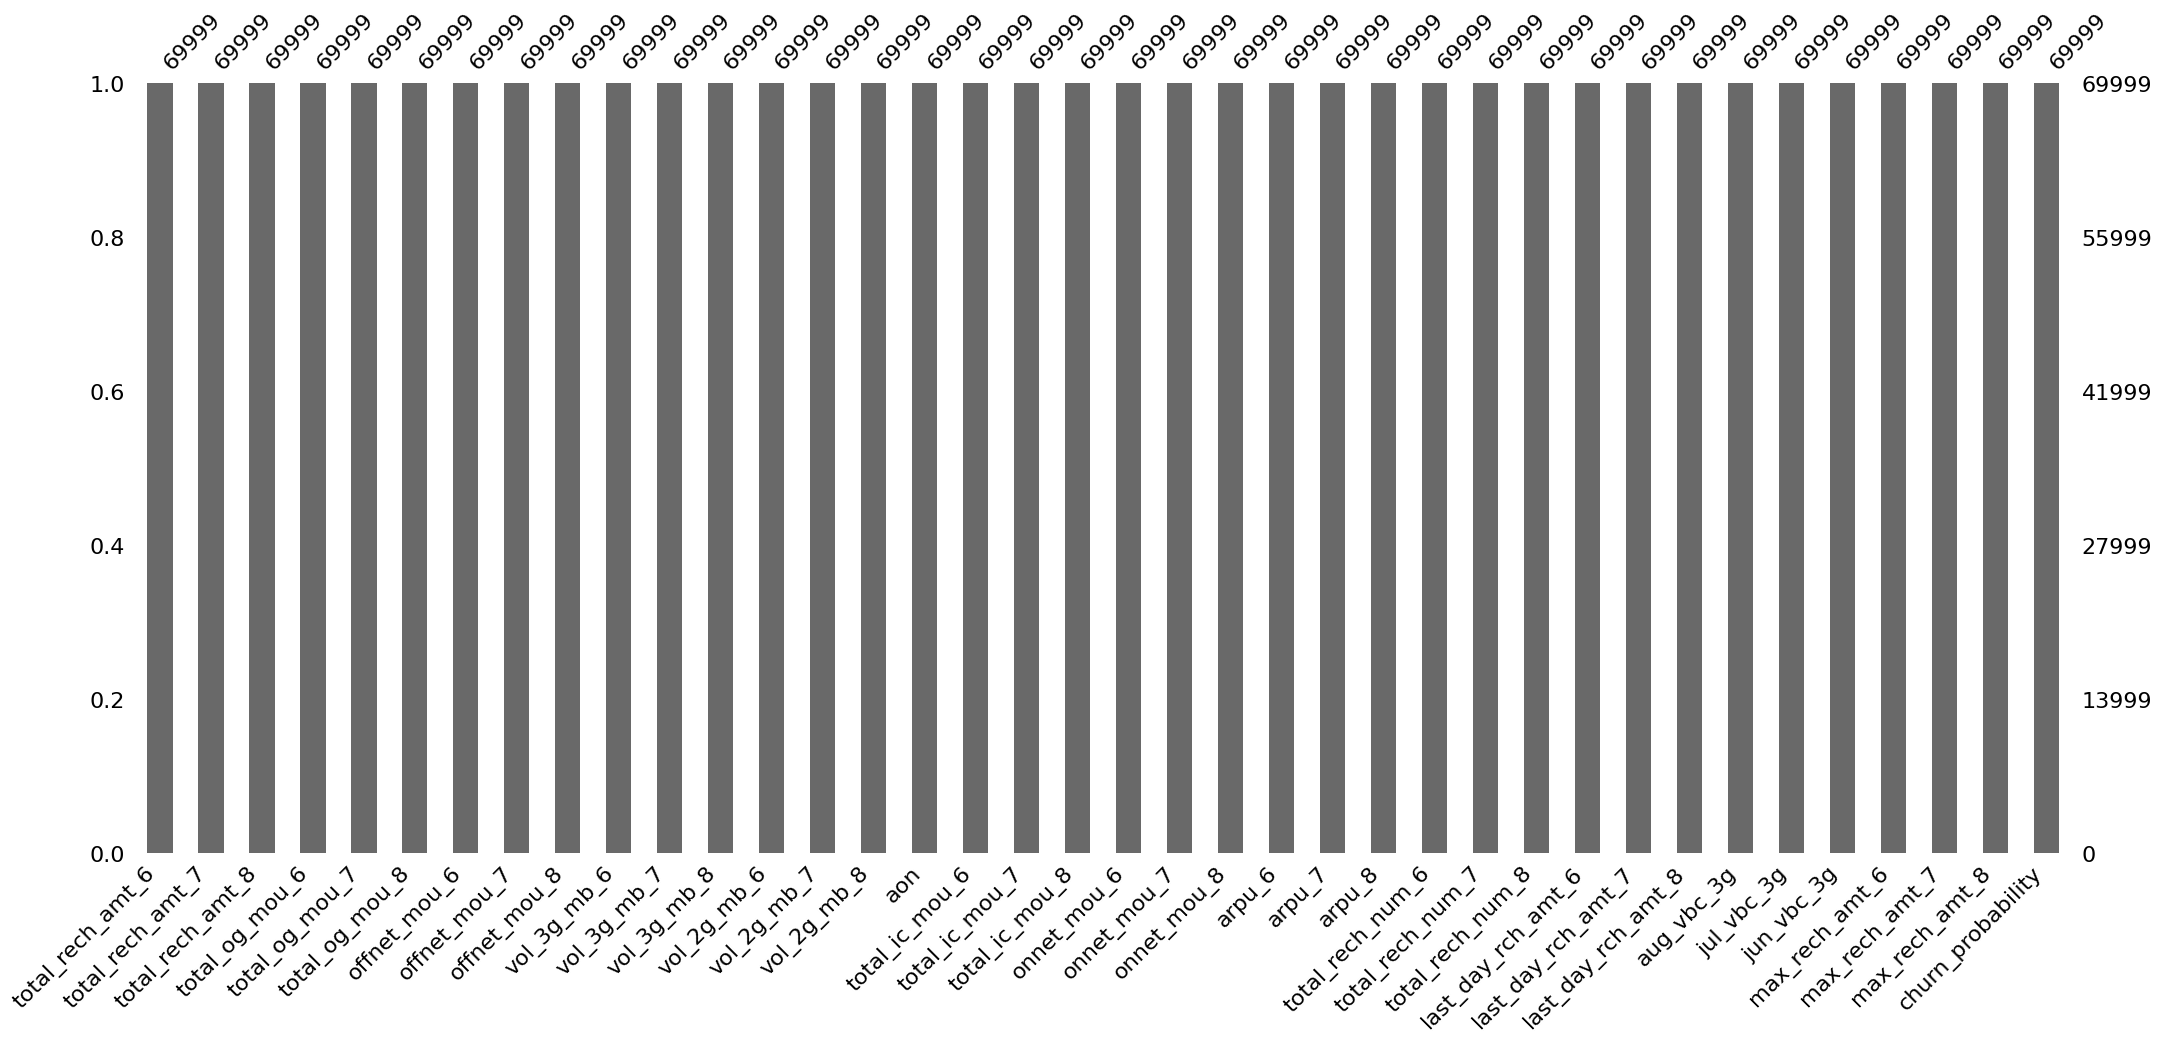

In [ ]:
msno.bar(data_tel_details)

In [ ]:
data_tel_details.shape

(69999, 38)

In [ ]:
data_tel_details.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
id                                                                         
0                 77                65                10           81.21   
1                  0               145                50            0.00   
2                 70               120                 0           56.49   
3                160               240               130           76.03   
4                290               136               122           63.26   

    total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
id                                                                             
0           221.68            3.63         32.24         96.68          2.33   
1            30.73           31.66          0.00         25.99         30.89   
2            99.36            0.00         53.99         82.05          0.00   
3            95.98           53.84         68.76         78.48         50.23   
4            42.94           15.76         56.99         38.11          9.63   

    vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  vol_2g_mb_7  \
id                                                                    
0           0.0         0.00          0.0          0.0         0.00   
1           0.0         3.96          0.0          0.0       352.91   
2           0.0         0.00          0.0          0.0         0.00   
3           0.0         0.00          0.0          0.0         0.00   
4           0.0         0.00          0.0        390.8       308.89   

    vol_2g_mb_8   aon  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
id                                                                      
0          0.00  1958           11.84           53.04           40.56   
1          0.00   710            3.44           39.44           25.04   
2          0.00   882          124.29           33.83           36.64   
3          0.00   982           95.11           50.18           83.84   
4        213.47   647           21.54            9.36           28.31   

    onnet_mou_6  onnet_mou_7  onnet_mou_8   arpu_6   arpu_7   arpu_8  \
id                                                                     
0         48.58       124.38         1.29   31.277   87.009    7.527   
1          0.00         0.00         0.00    0.000  122.787   42.953   
2          0.53        15.93         0.00   60.806  103.176    0.000   
3          7.26        16.01         0.00  156.362  205.260  111.095   
4         21.28         4.83         6.13  240.708  128.191  101.565   

    total_rech_num_6  total_rech_num_7  total_rech_num_8  last_day_rch_amt_6  \
id                                                                             
0                  3                 2                 2                  65   
1                  3                 4                 5                   0   
2                  2                 4                 2                  70   
3                  2                 4                 3                 110   
4                 13                10                 8                  25   

    last_day_rch_amt_7  last_day_rch_amt_8  aug_vbc_3g  jul_vbc_3g  \
id                                                                   
0                   65                   0         0.0         0.0   
1                    0                   0         0.0         0.0   
2                   50                   0         0.0         0.0   
3                  110                  50         0.0         0.0   
4                   10                  30         0.0         0.0   

    jun_vbc_3g  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
id                                                               
0          0.0              65              65              10   
1          0.0               0             145              50   
2          0.0              70              70               0   
3          0.

In [ ]:
data_tel_details.describe()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
count      69999.000000      69999.000000      69999.000000    69999.000000   
mean         328.139788        322.376363        323.846355      306.451436   
std          404.211068        411.070120        426.181405      465.502866   
min            0.000000          0.000000          0.000000        0.000000   
25%          110.000000        100.000000         90.000000       44.780000   
50%          229.000000        220.000000        225.000000      145.280000   
75%          438.000000        430.000000        436.000000      374.305000   
max        35190.000000      40335.000000      45320.000000    10674.030000   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
count    69999.000000    69999.000000  69999.000000  69999.000000   
mean       310.572674      304.513065    191.010582    189.585401   
std        479.131770      477.936832    312.900706    318.492632   
min          0.000000        0.000000      0.000000      0.000000   
25%         42.910000       38.710000     28.790000     26.690000   
50%        141.230000      138.360000     89.810000     85.590000   
75%        380.045000      370.895000    223.540000    218.350000   
max       8285.640000    14043.060000   8362.360000   7043.980000   

       offnet_mou_8   vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8   vol_2g_mb_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     186.146273    122.171882    128.934444    135.486541     51.773924   
std      318.453812    554.869965    554.096072    568.310234    212.513909   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       23.780000      0.000000      0.000000      0.000000      0.000000   
50%       83.010000      0.000000      0.000000      0.000000      0.000000   
75%      216.410000      0.000000      0.000000      0.000000      0.000000   
max    14007.340000  45735.400000  28144.120000  30036.060000  10285.900000   

        vol_2g_mb_7   vol_2g_mb_8           aon  total_ic_mou_6  \
count  69999.000000  69999.000000  69999.000000    69999.000000   
mean      51.240204     50.127506   1220.639709      199.710640   
std      211.114667    213.101403    952.426321      290.114823   
min        0.000000      0.000000    180.000000        0.000000   
25%        0.000000      0.000000    468.000000       38.640000   
50%        0.000000      0.000000    868.000000      114.780000   
75%        0.000000      0.000000   1813.000000      251.070000   
max     7873.550000  11117.610000   4337.000000     7716.140000   

       total_ic_mou_7  total_ic_mou_8   onnet_mou_6   onnet_mou_7  \
count    69999.000000    69999.000000  69999.000000  69999.000000   
mean       201.878029      198.486034    127.887939    128.754731   
std        296.771338      288.336731    295.115497    306.326345   
min          0.000000        0.000000      0.000000      0.000000   
25%         41.340000       38.290000      5.430000      4.910000   
50%        116.330000      114.610000     30.830000     29.160000   
75%        249.470000      249.710000    113.100000    108.940000   
max       9699.010000    10830.380000   7376.710000   8157.780000   

        onnet_mou_8        arpu_6        arpu_7        arpu_8  \
count  69999.000000  69999.000000  69999.000000  69999.000000   
mean     125.943607    283.134365    278.185912    278.858826   
std      304.990552    334.213918    344.366927    351.924315   
min        0.000000  -2258.709000  -1289.715000   -945.808000   
25%        4.110000     93.581000     86.714000     84.095000   
50%       27.840000    197.484000    191.588000    192.234000   
75%      106.280000    370.791000    365.369500    369.909000   
max    10752.560000  27731.088000  35145.834000  33543.624000   

       total_rech_num_6  total_rech_num_7  total_rech_num_8  \
count      69999.000000      69999.000000      69999.000000   
mean           7.566522

# 3. EDA

### Univariate analysis

<Axes: >

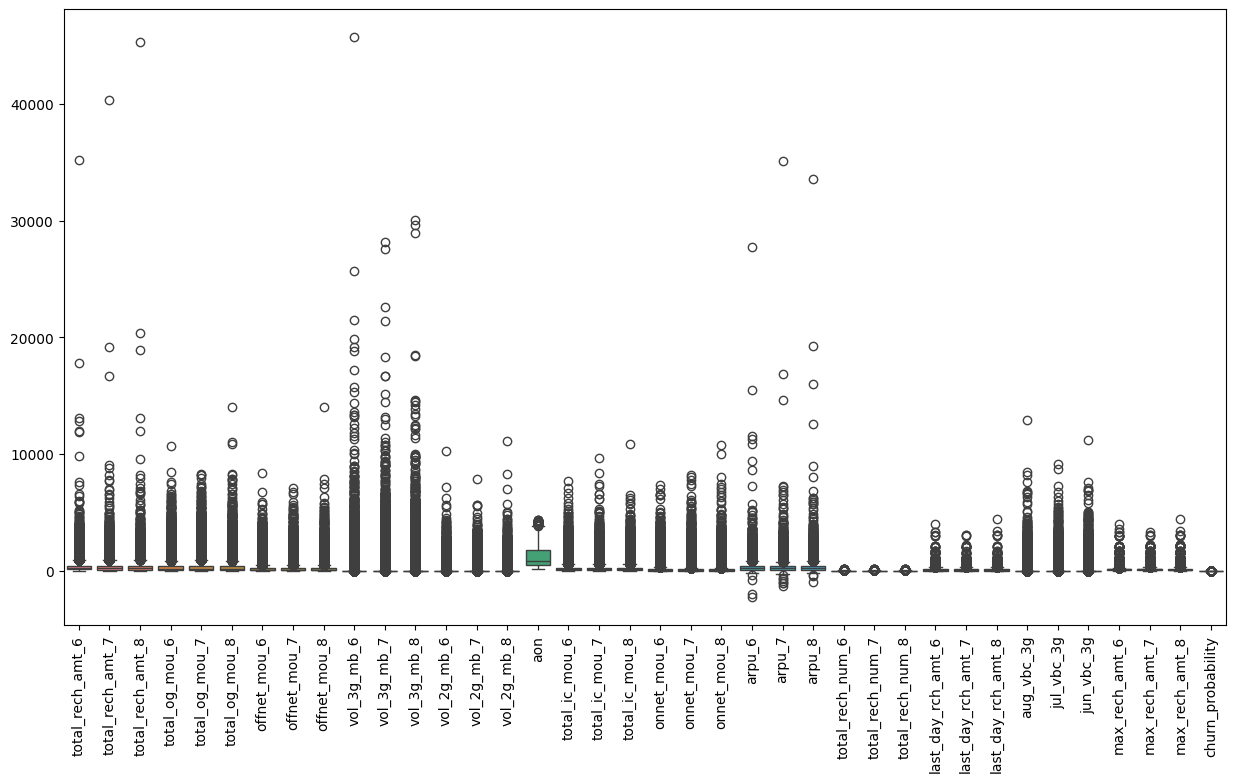

In [ ]:
# Generate a boxplot for all the variables
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = data_tel_details)

#### Observation
- As observer there are outliers in many variables

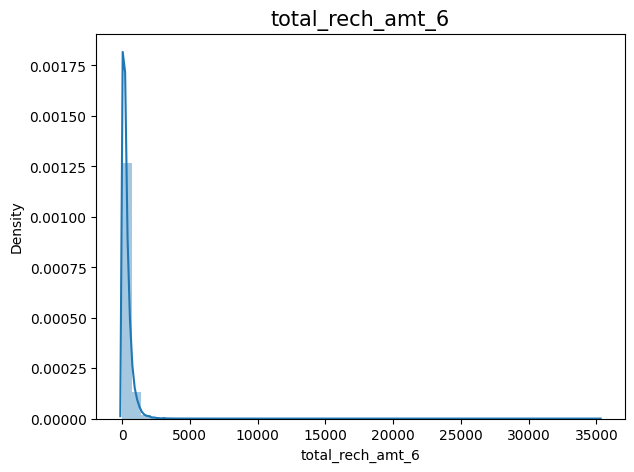

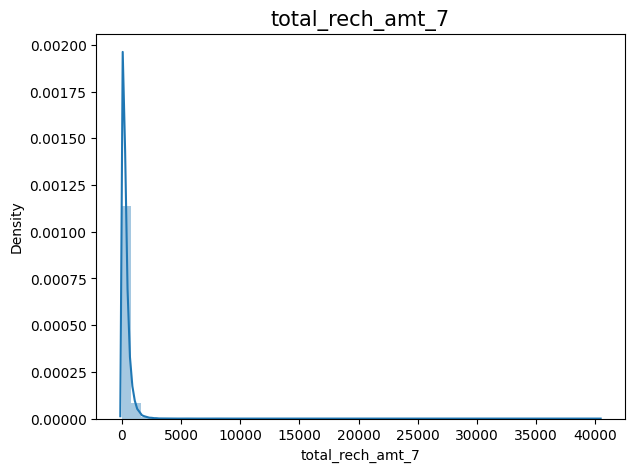

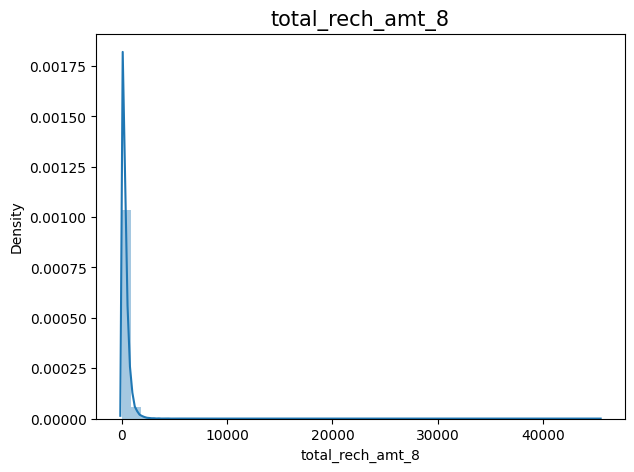

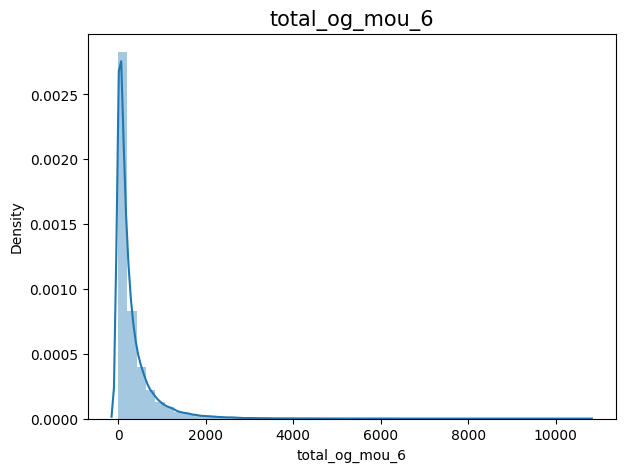

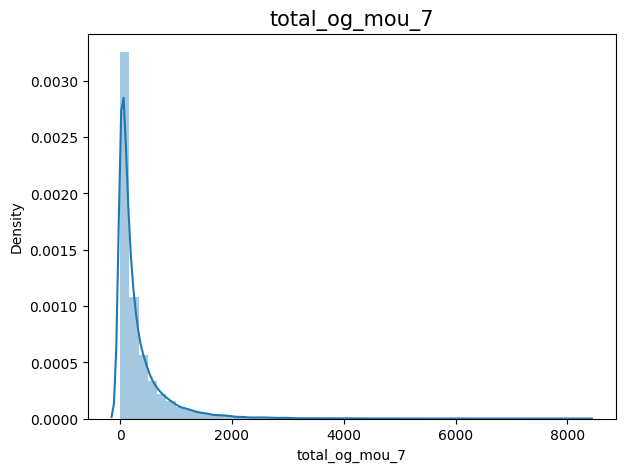

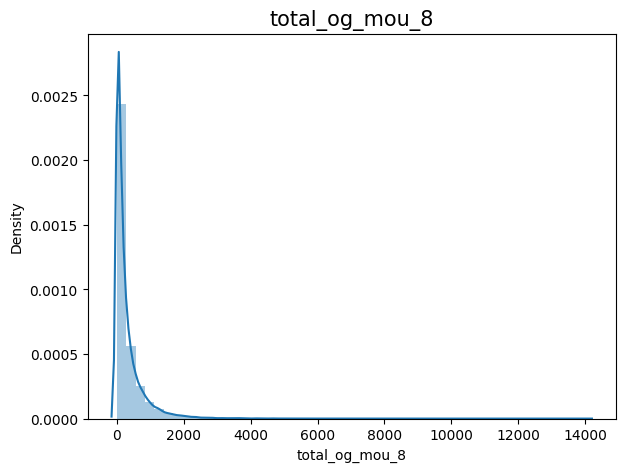

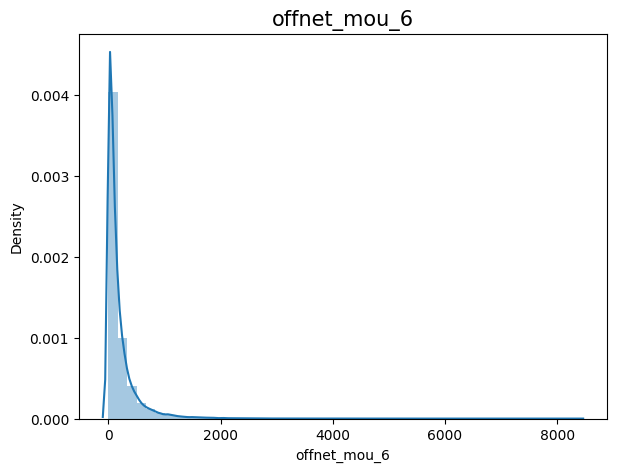

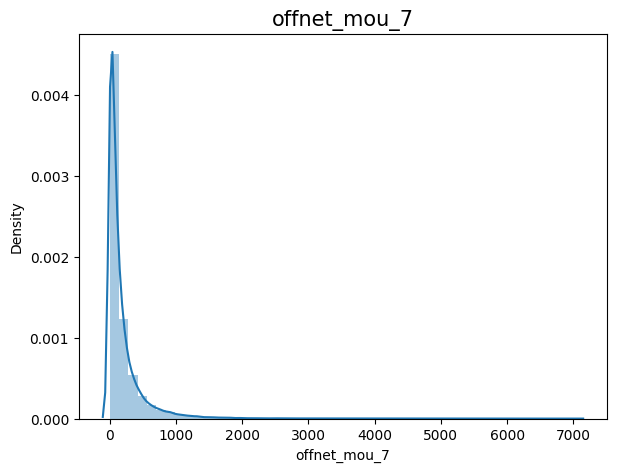

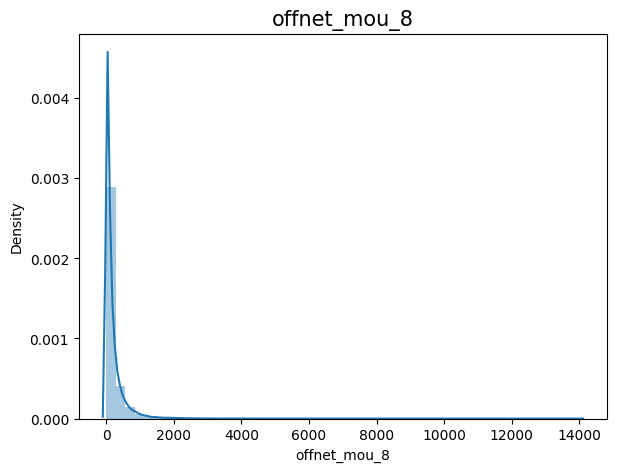

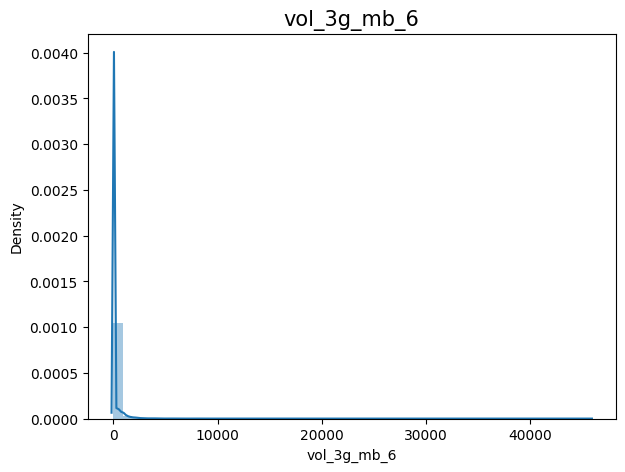

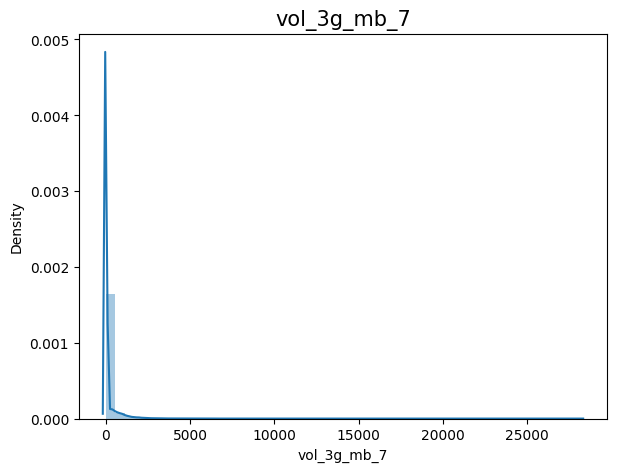

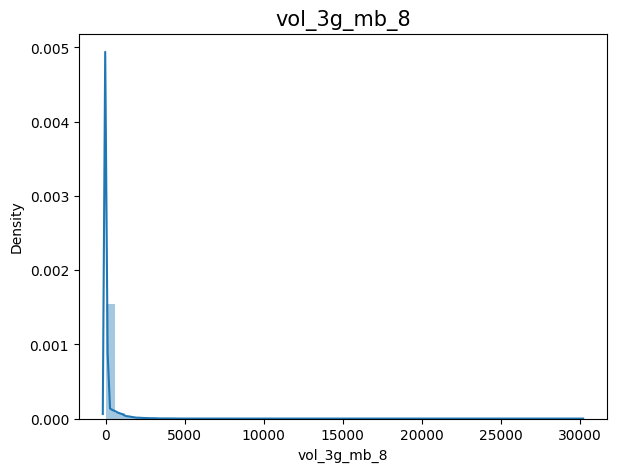

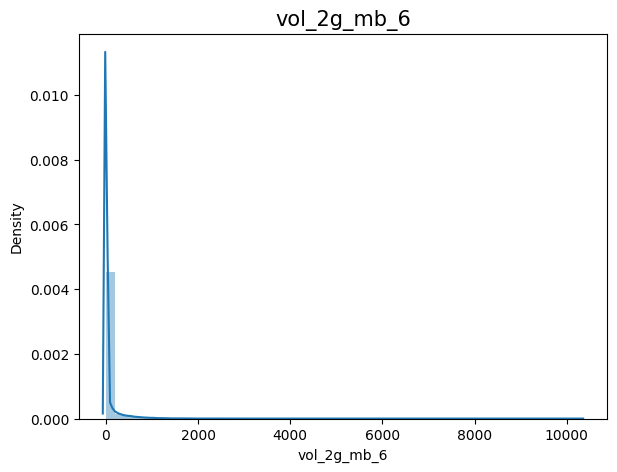

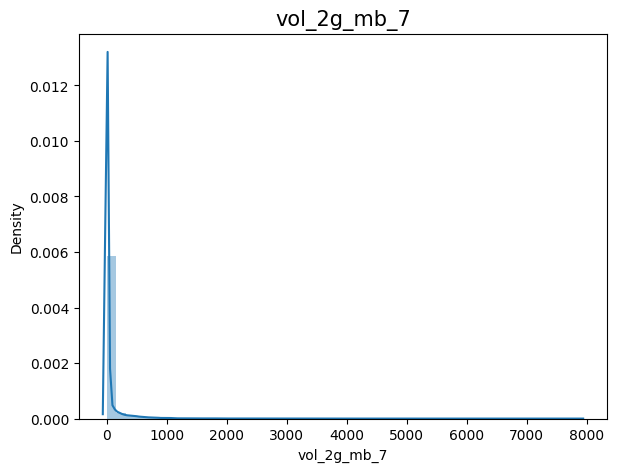

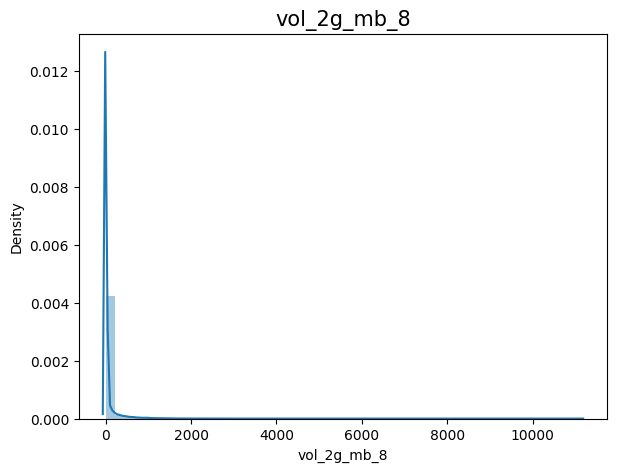

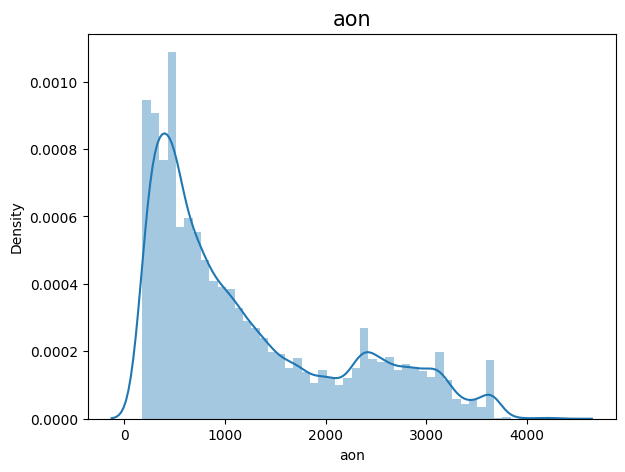

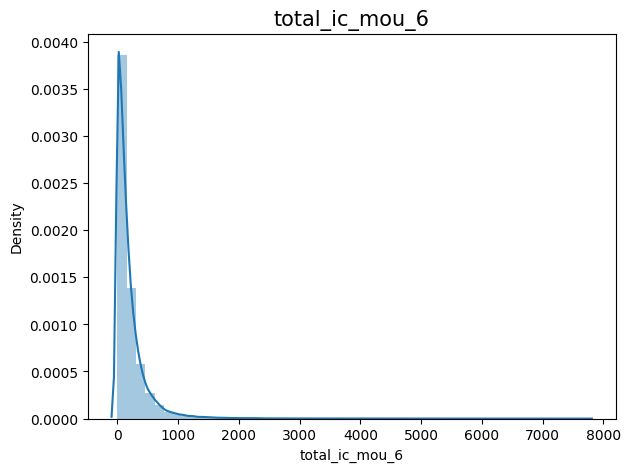

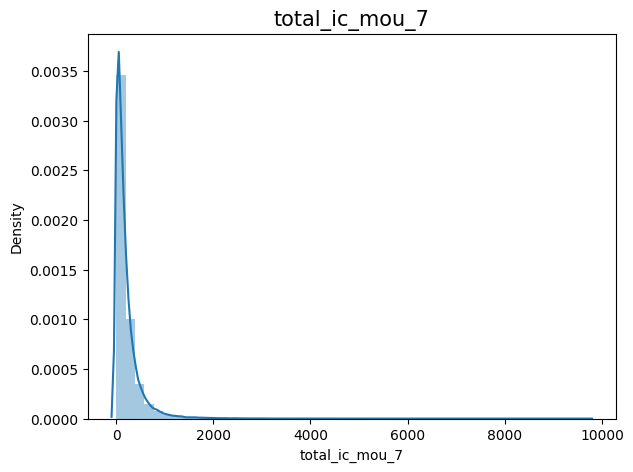

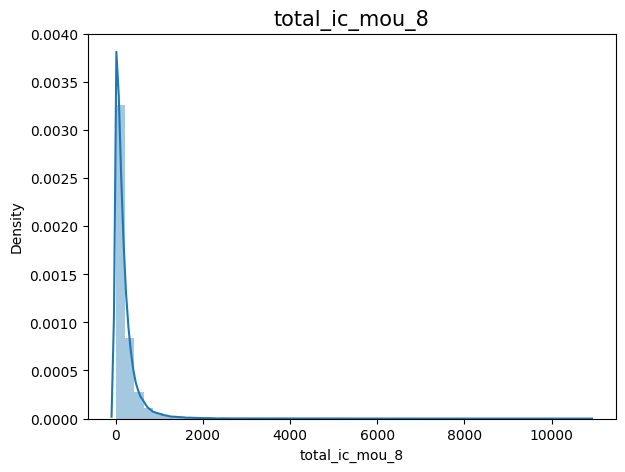

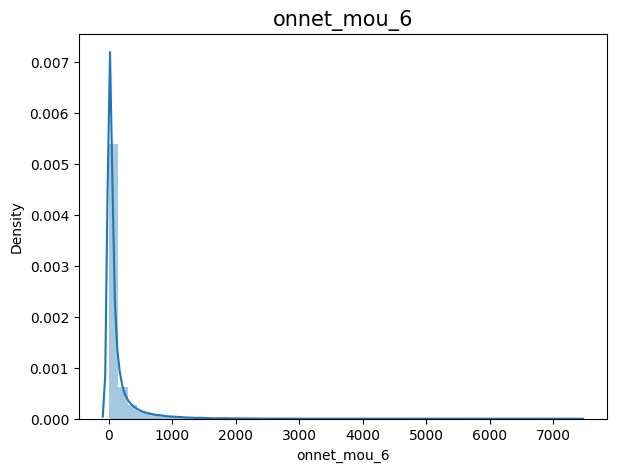

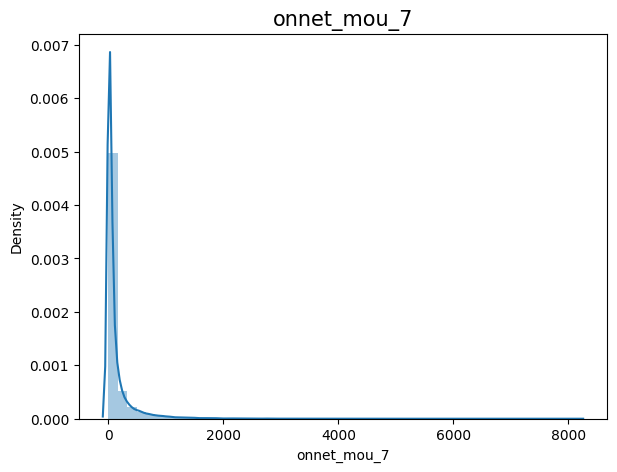

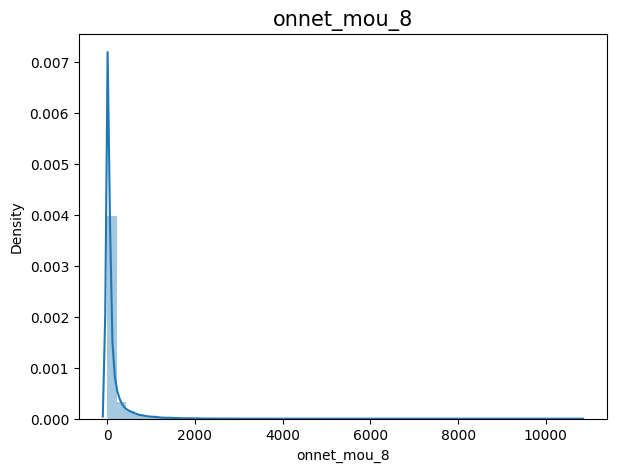

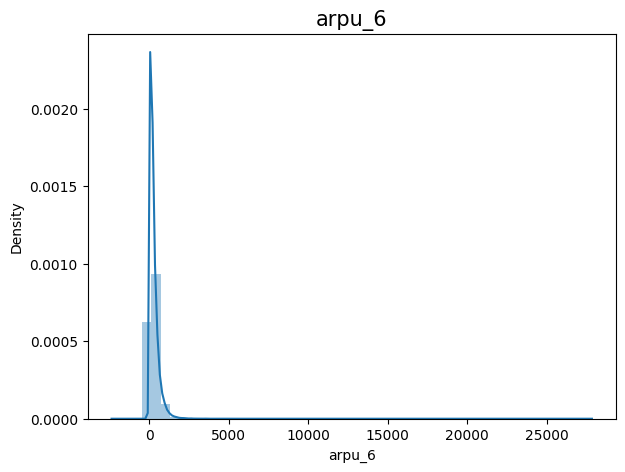

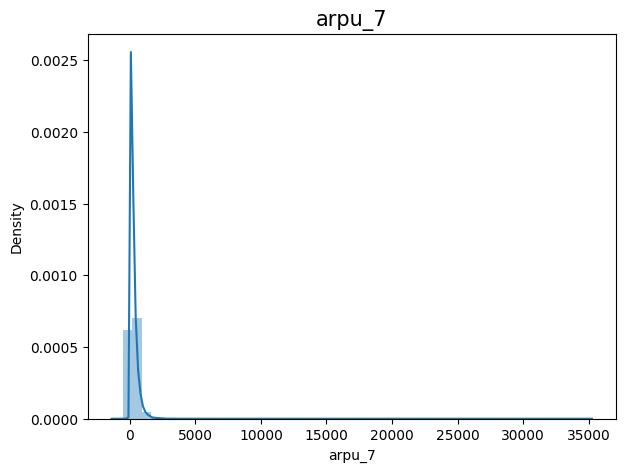

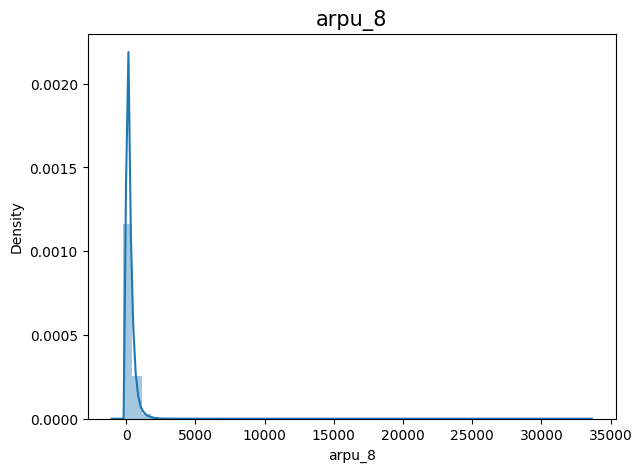

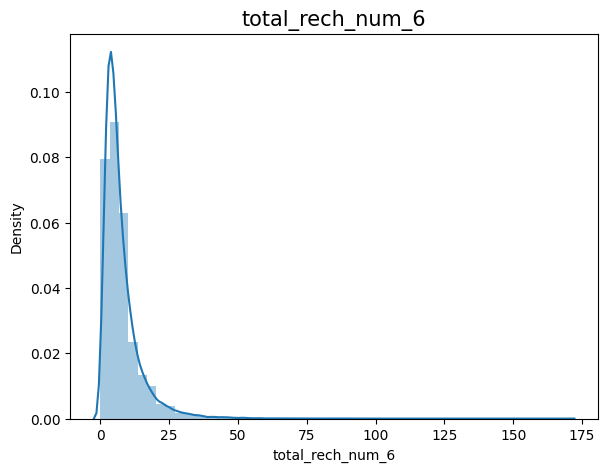

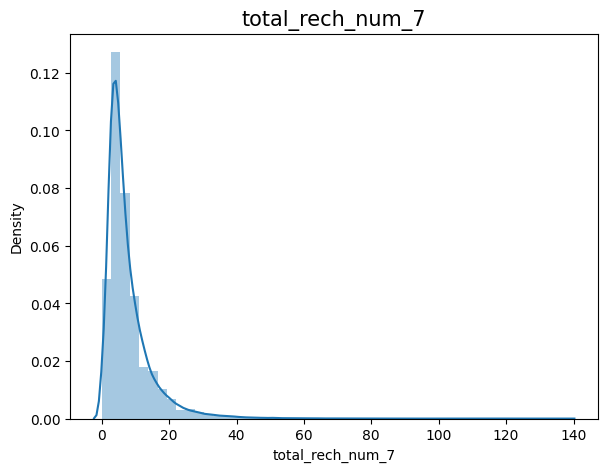

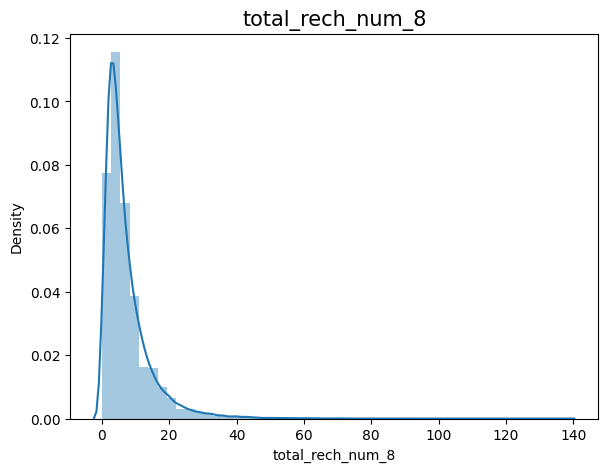

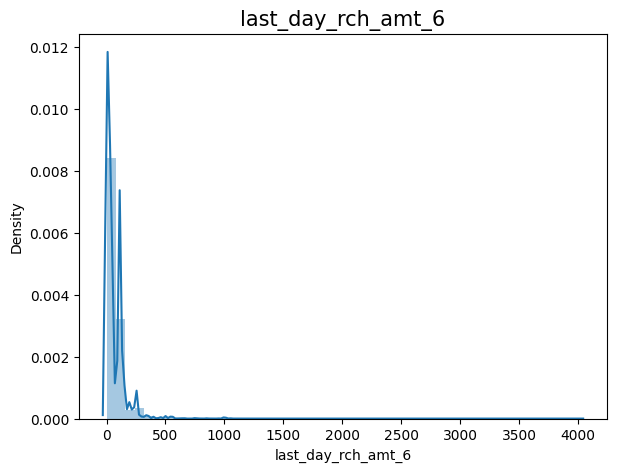

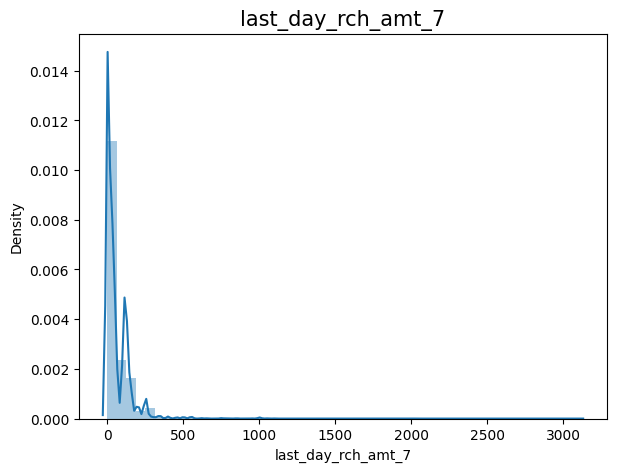

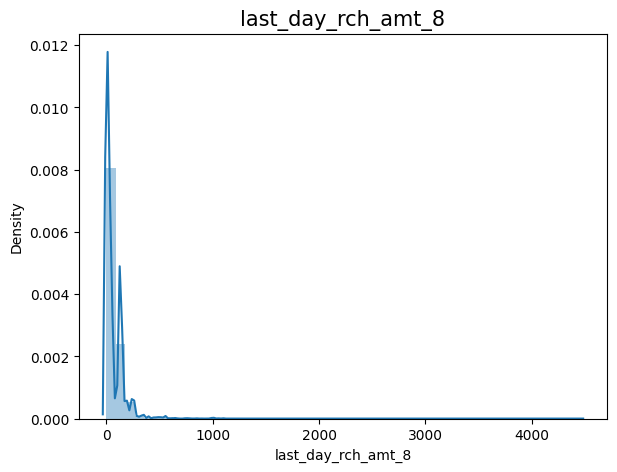

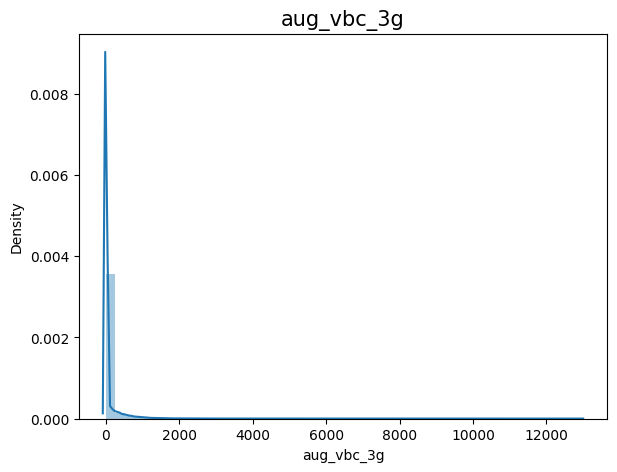

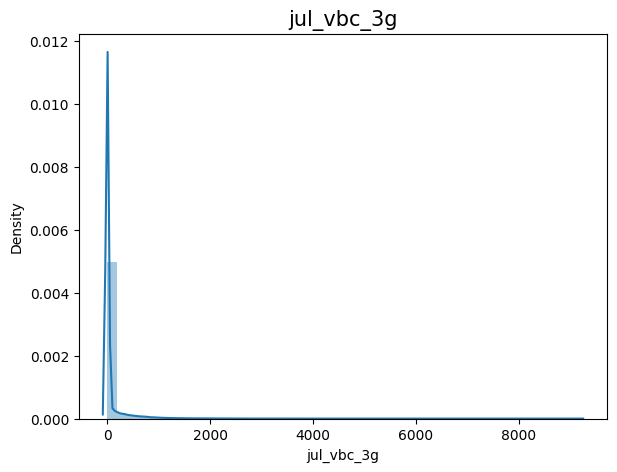

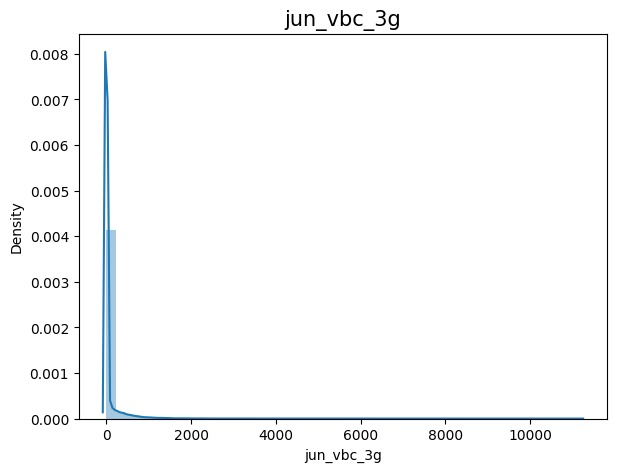

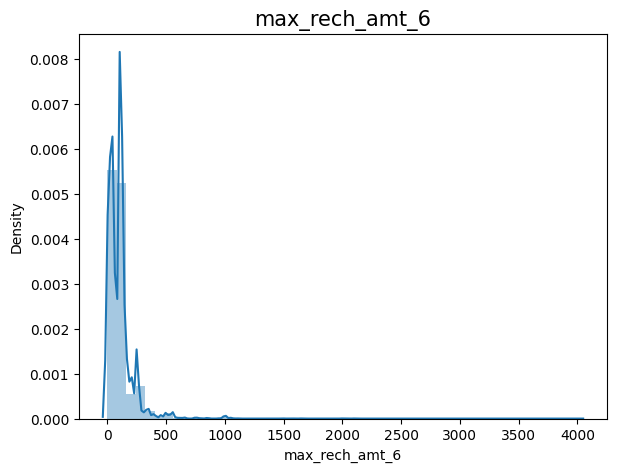

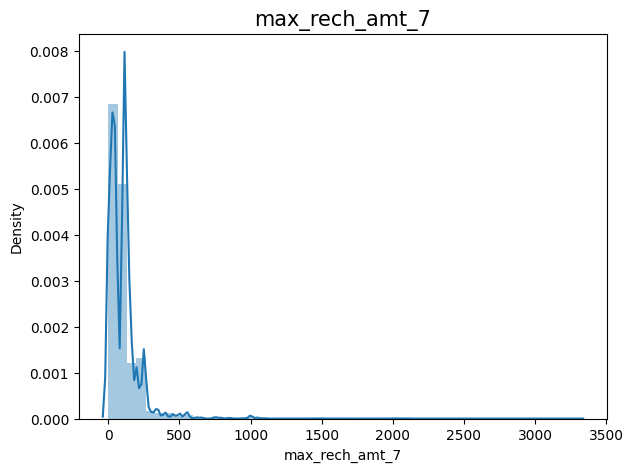

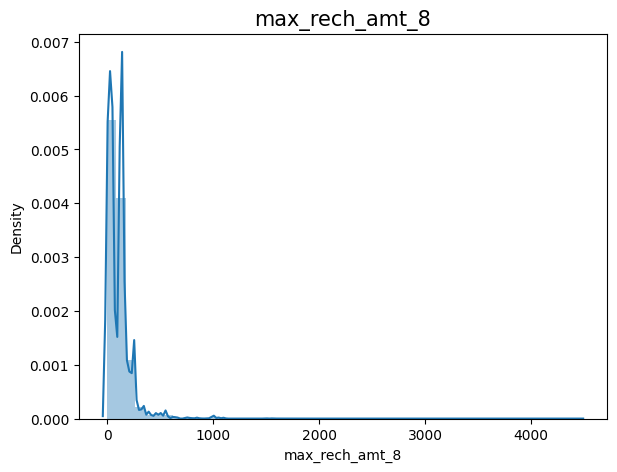

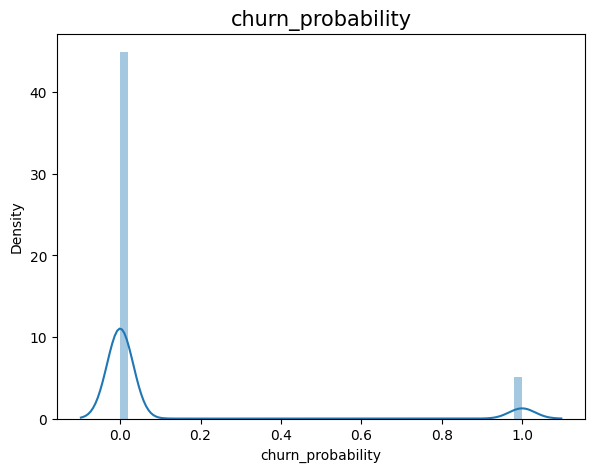

In [ ]:
#Check the histogram for univariate analysis
for col in data_tel_details.columns:
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 15})
    sns.distplot(data_tel_details[col])

### Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [ ]:
# Function to deal with outliers
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

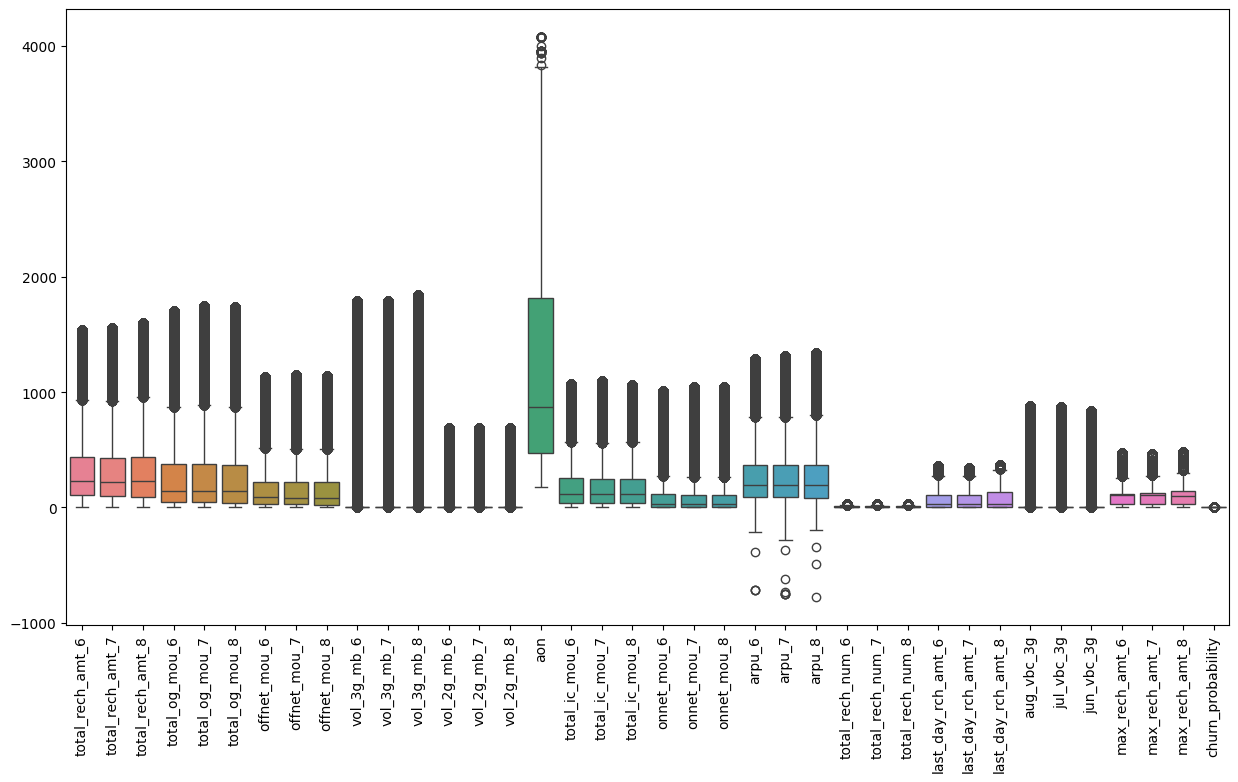

In [ ]:
# Applying the outliers for all the variables
data_tel_details_1 = data_tel_details.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = data_tel_details_1)

#### Observation
- Outliers have been reduced in the above chart

In [ ]:
data_tel_details_1.shape

(69999, 38)

### Bivariate analysis

<Axes: >

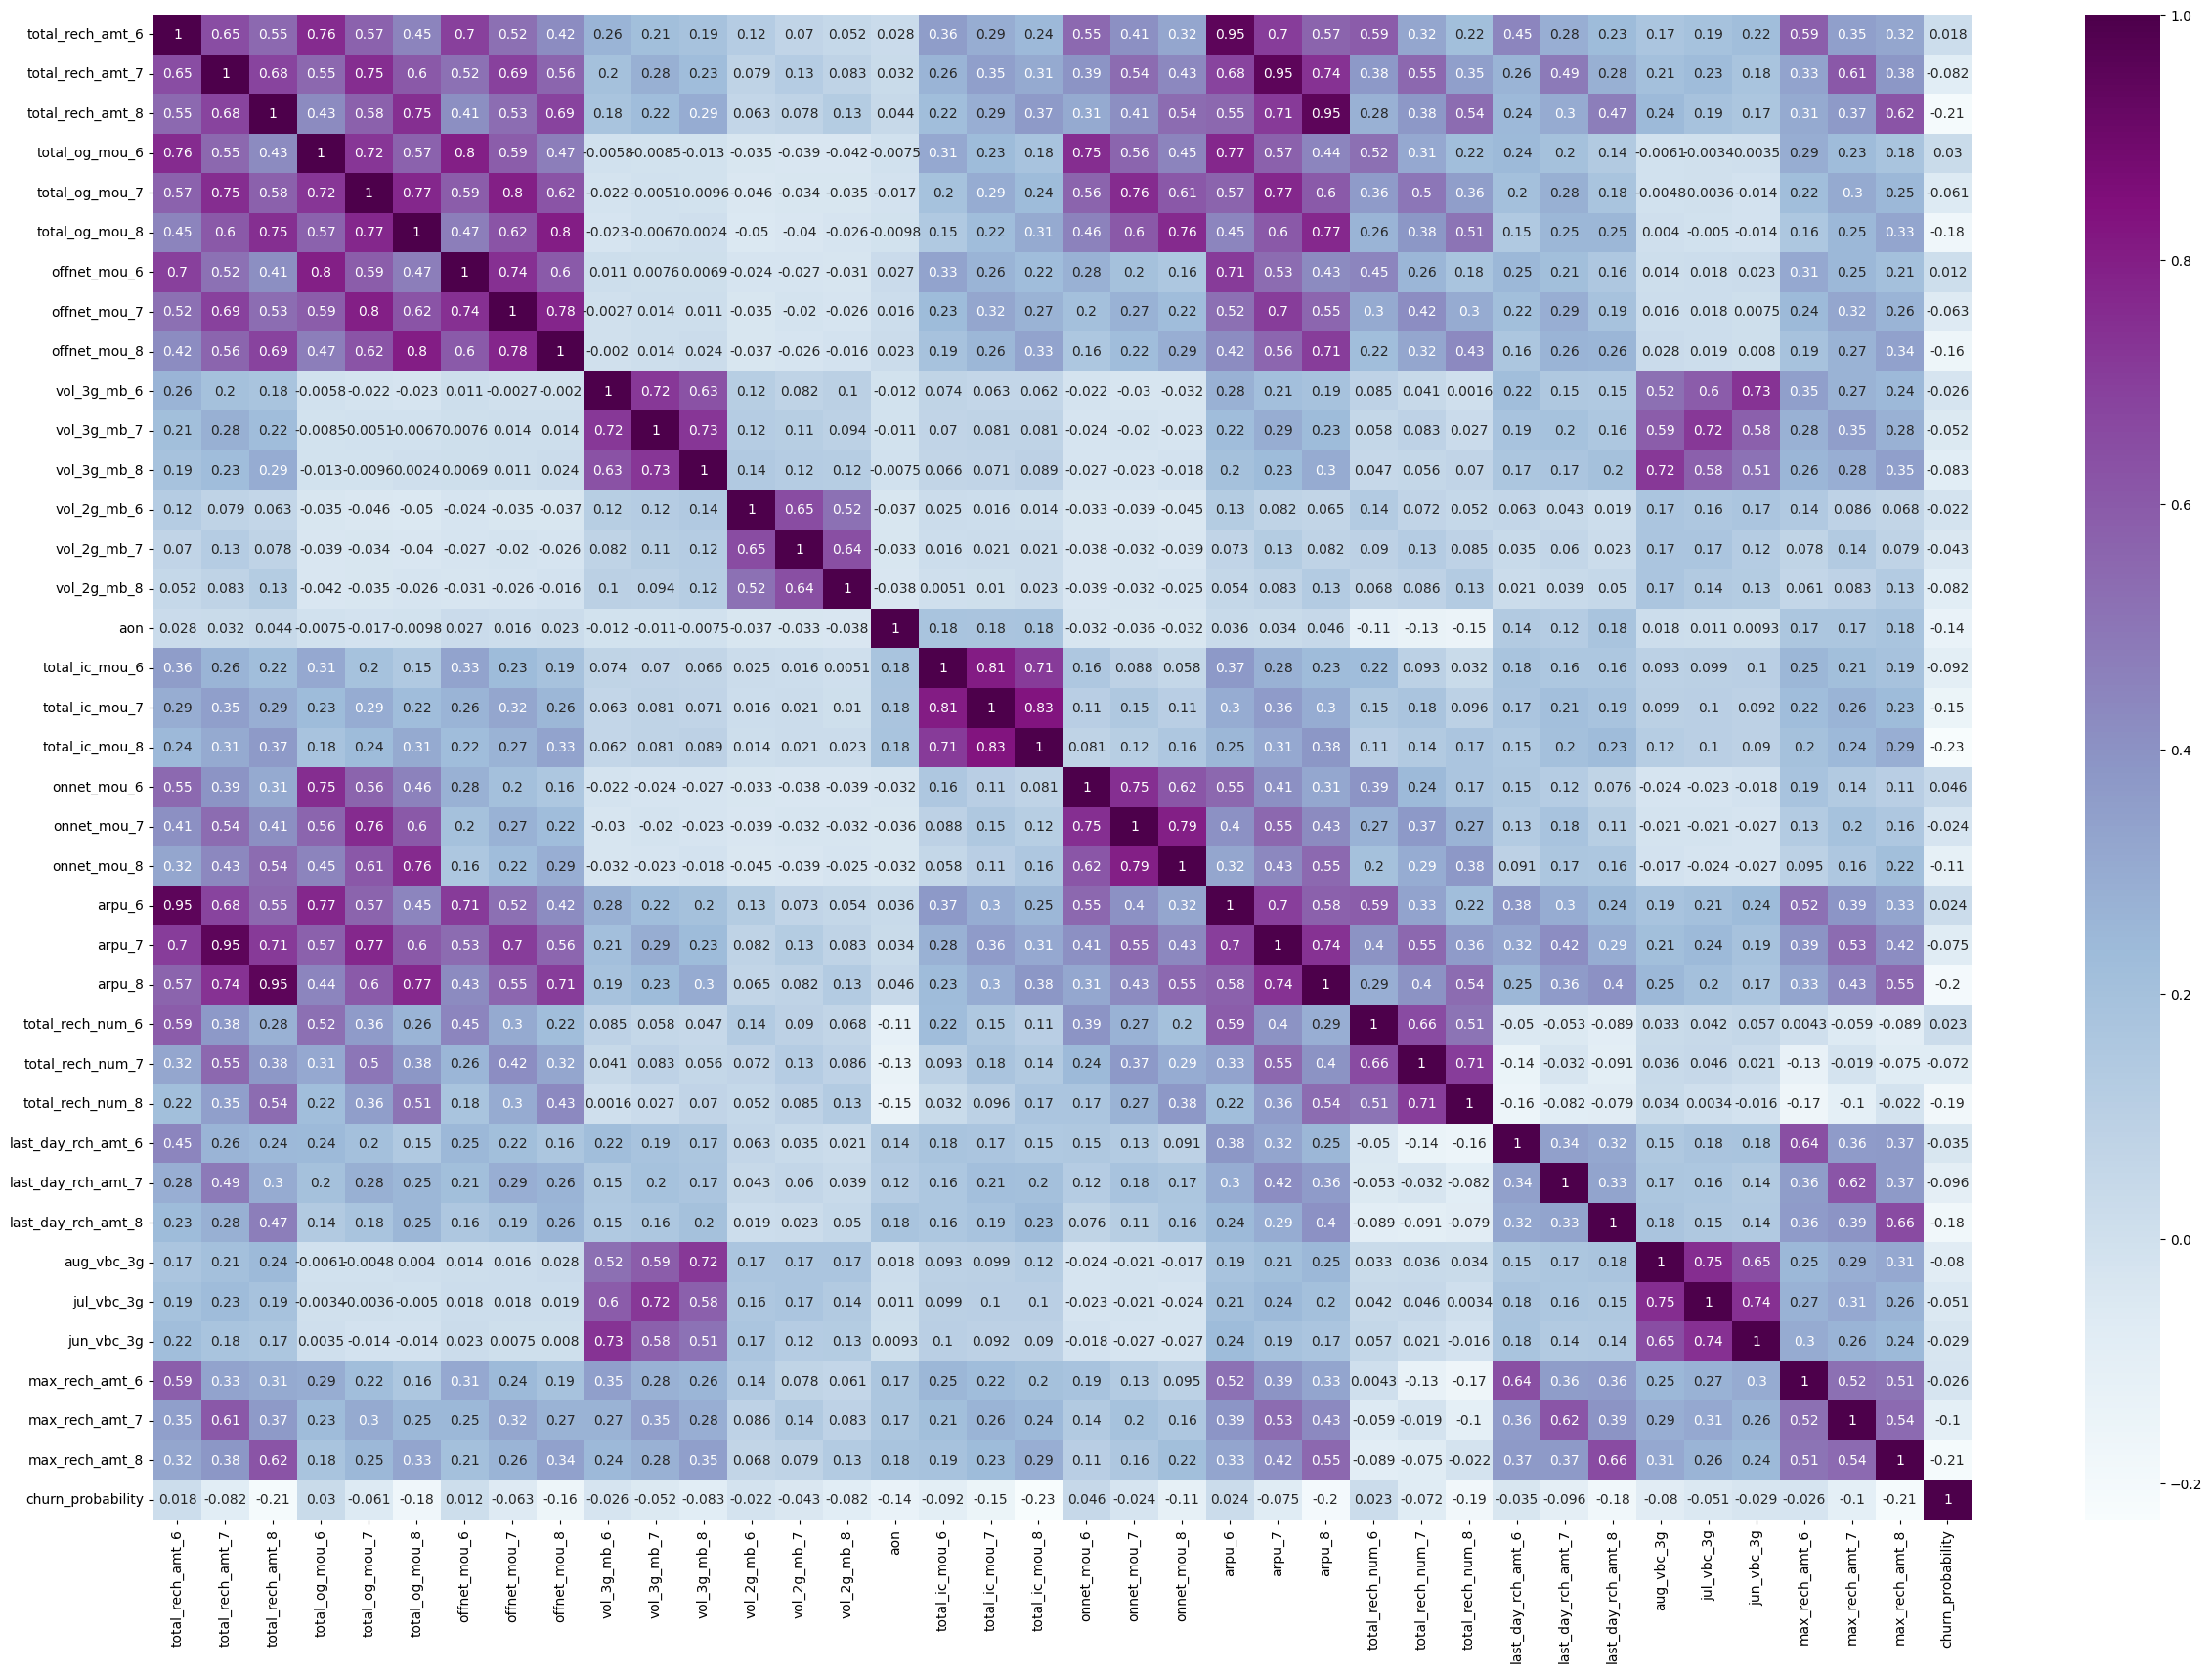

In [ ]:
# Plot heatmap to detect correlations among numerical variables
plt.figure(figsize=(30,20))
sns.heatmap(data_tel_details_1.corr(), annot=True, cmap='BuPu')

#### Observation : 

- arpu & total_rech_amt has 95% corr

- arpu & total_og_mou has 78% corr

- vbc & vol_3g_mb has 75% corr

- total_og_mou & total_rech_amt has 76% corr

- total_rech_amt & offnet_mou has corr

- max_rech_amt & last_day_rch_amt & total_rech_amt has high corr

- Dropping arpu, vol_3g_mb, total_og_mou due, offnet_mou, max_rech_amt to high corr

In [ ]:
# Highly correlated columns list
high_corr_cols = ['arpu_6','arpu_7','arpu_8','total_og_mou_6','total_og_mou_7','total_og_mou_8', 'vol_3g_mb_6',
                 'vol_3g_mb_7', 'vol_3g_mb_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'max_rech_amt_6',
                 'max_rech_amt_7', 'max_rech_amt_8']

In [ ]:
#dropping the highly corr columns
data_tel_details_1.drop(high_corr_cols, axis=1, inplace=True)

<Axes: >

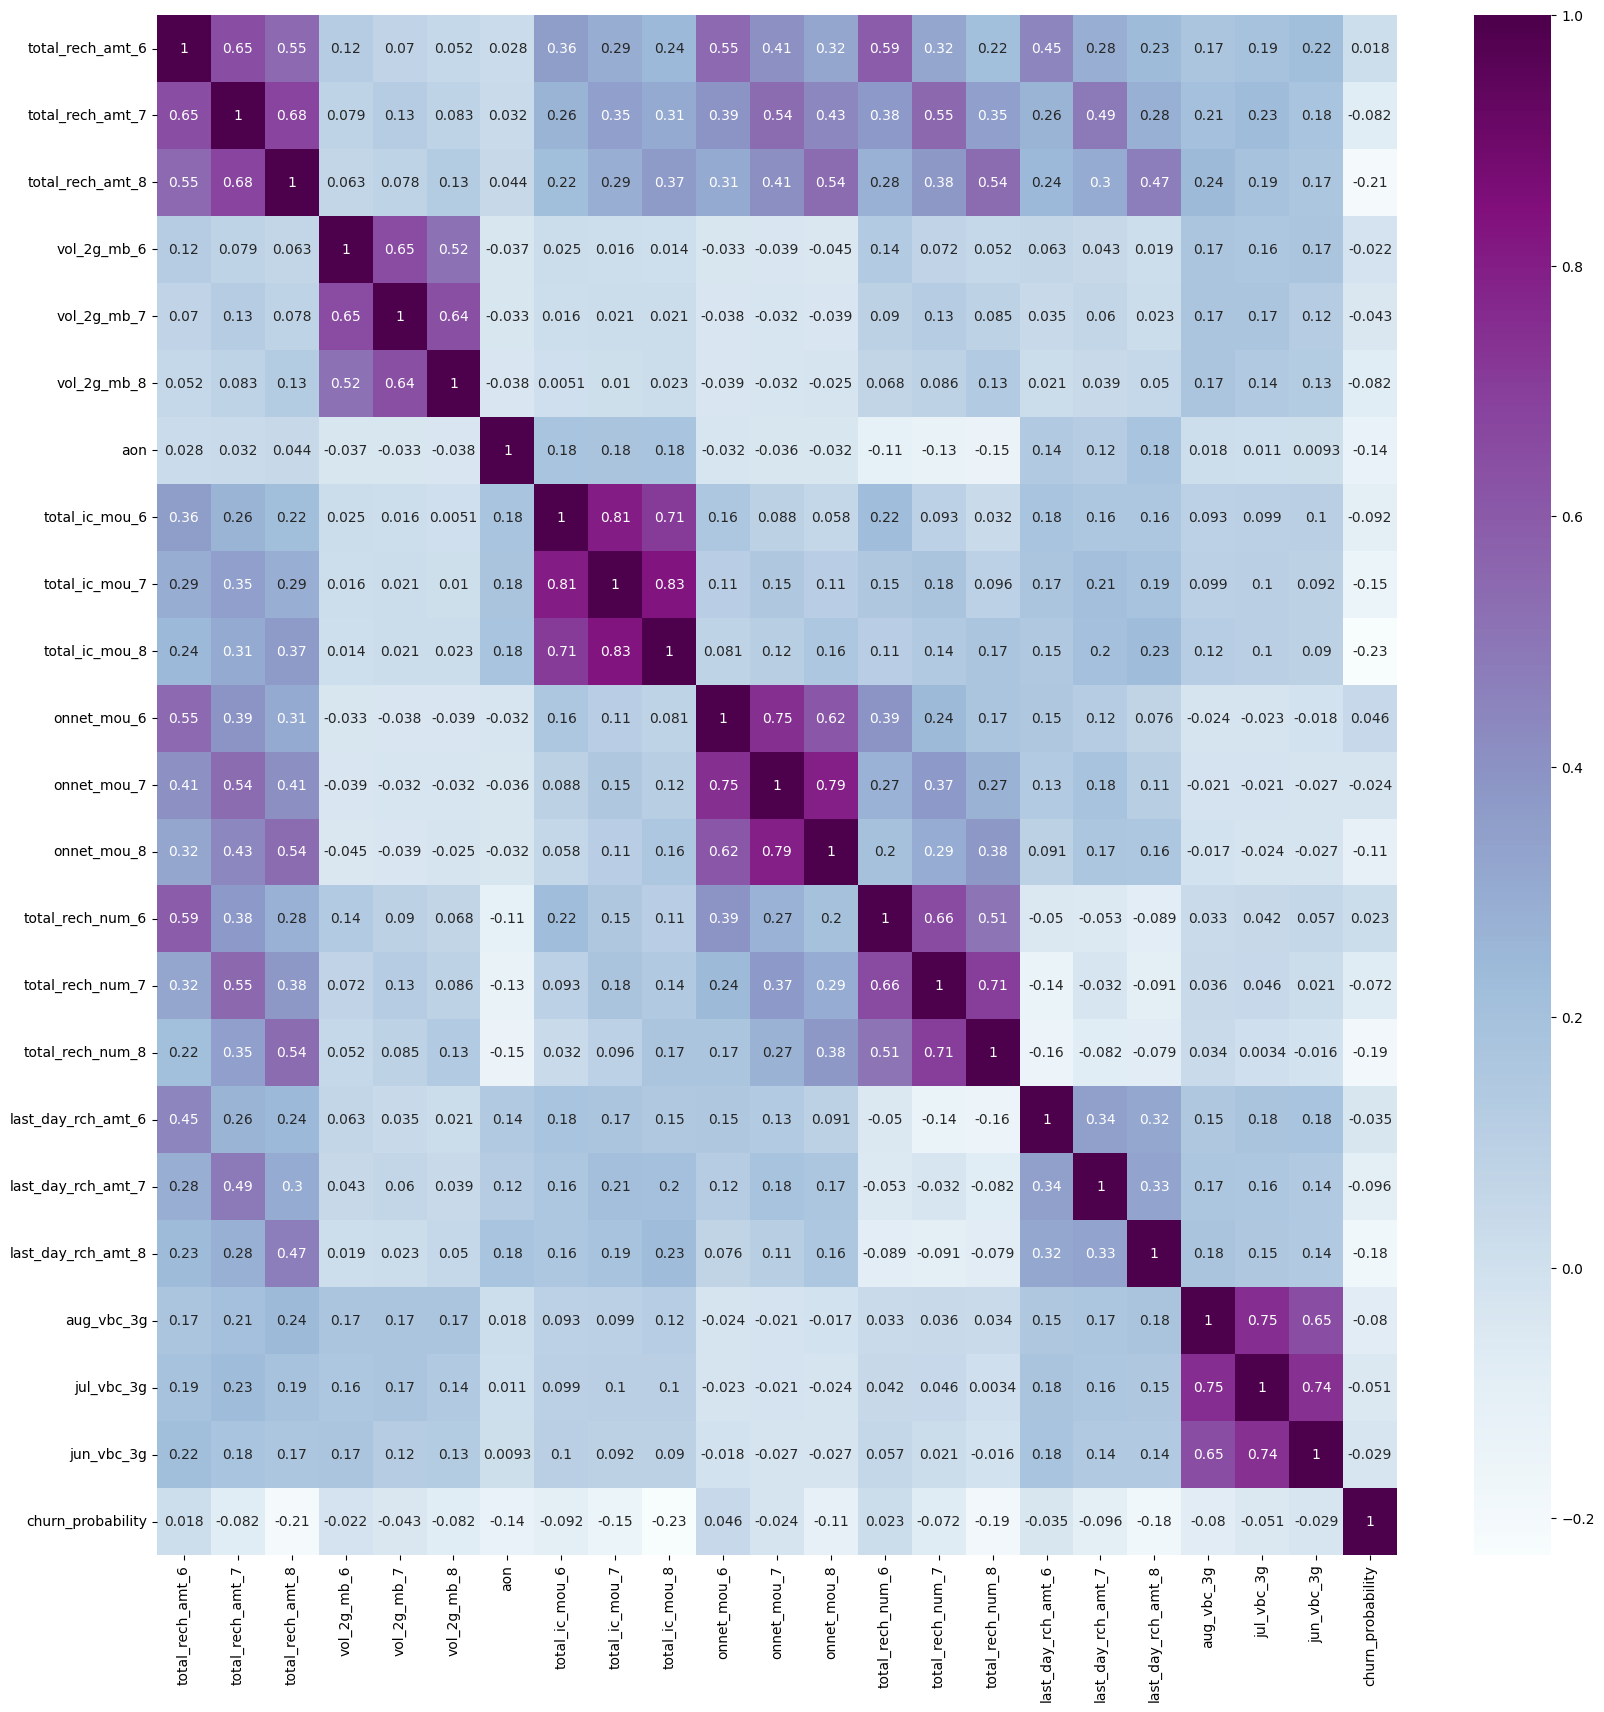

In [ ]:
# Plot heatmap to detect correlations among numerical variables
plt.figure(figsize=(20,20))
sns.heatmap(data_tel_details_1.corr(), annot=True, cmap='BuPu')

#### Checking the recharge details of people who have churned

In [ ]:
churned_data = data_tel_details_1[data_tel_details_1["churn_probability"] == 1]
churned_data

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  vol_2g_mb_6  \
id                                                                         
8                 200.0               0.0             150.0          0.0   
31                104.0               0.0               0.0          0.0   
33                505.0               0.0             252.0          0.0   
41                 66.0             140.0               0.0          0.0   
55                 90.0             126.0             120.0          0.0   
...                 ...               ...               ...          ...   
69942               0.0               0.0               0.0          0.0   
69950            1470.0               0.0               0.0          0.0   
69956             106.0               0.0               0.0          0.0   
69962               0.0             287.0               0.0          0.0   
69983             342.0             478.0              67.0          0.0   

       vol_2g_mb_7  vol_2g_mb_8     aon  total_ic_mou_6  total_ic_mou_7  \
id                                                                        
8              0.0          0.0  2455.0            0.00            0.00   
31             0.0          0.0   303.0           43.43            0.99   
33             0.0          0.0   457.0            0.00            0.00   
41             0.0          0.0   194.0            5.30           27.08   
55             0.0          0.0   789.0           36.86           43.84   
...            ...          ...     ...             ...             ...   
69942          0.0          0.0   516.0            0.00            0.00   
69950          0.0          0.0   326.0           26.06            0.00   
69956          0.0          0.0  1231.0            0.00            0.00   
69962          0.0          0.0   191.0            0.00          759.91   
69983          0.0          0.0   565.0           22.59           41.49   

       total_ic_mou_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                             
8                0.00         0.00         0.00         0.00   
31               0.00       412.71        89.09         0.00   
33               0.00         0.00         0.00         0.00   
41               0.00        37.75       166.74         0.00   
55              39.64        71.46        90.16        15.19   
...               ...          ...          ...          ...   
69942            0.00         6.63       121.43         0.00   
69950            0.00        43.93         0.00         0.00   
69956            0.00         0.00         0.00         0.00   
69962            0.00         0.00        52.91         0.00   
69983           43.78       399.01       283.63       184.43   

       total_rech_num_6  total_rech_num_7  total_rech_num_8  \
id                                                            
8                   2.0               3.0               1.0   
31                  1.0               0.0               0.0   
33                  1.0               3.0               2.0   
41                  2.0              10.0               3.0   
55                  4.0               7.0               5.0   
...                 ...               ...               ...   
69942               1.0               4.0               5.0   
69950              14.0               2.0               4.0   
69956               1.0               0.0               0.0   
69962               3.0               5.0               1.0   
69983               4.0               5.0               2.0   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  aug_vbc_3g  \
id                                                                              
8              200.000000                 0.0               150.0         0.0   
31             104.000000                 0.0                 0.0         0.0   
33             357.291575                 0.0               252.0

<Axes: xlabel='id'>

<Figure size 2000x1000 with 0 Axes>

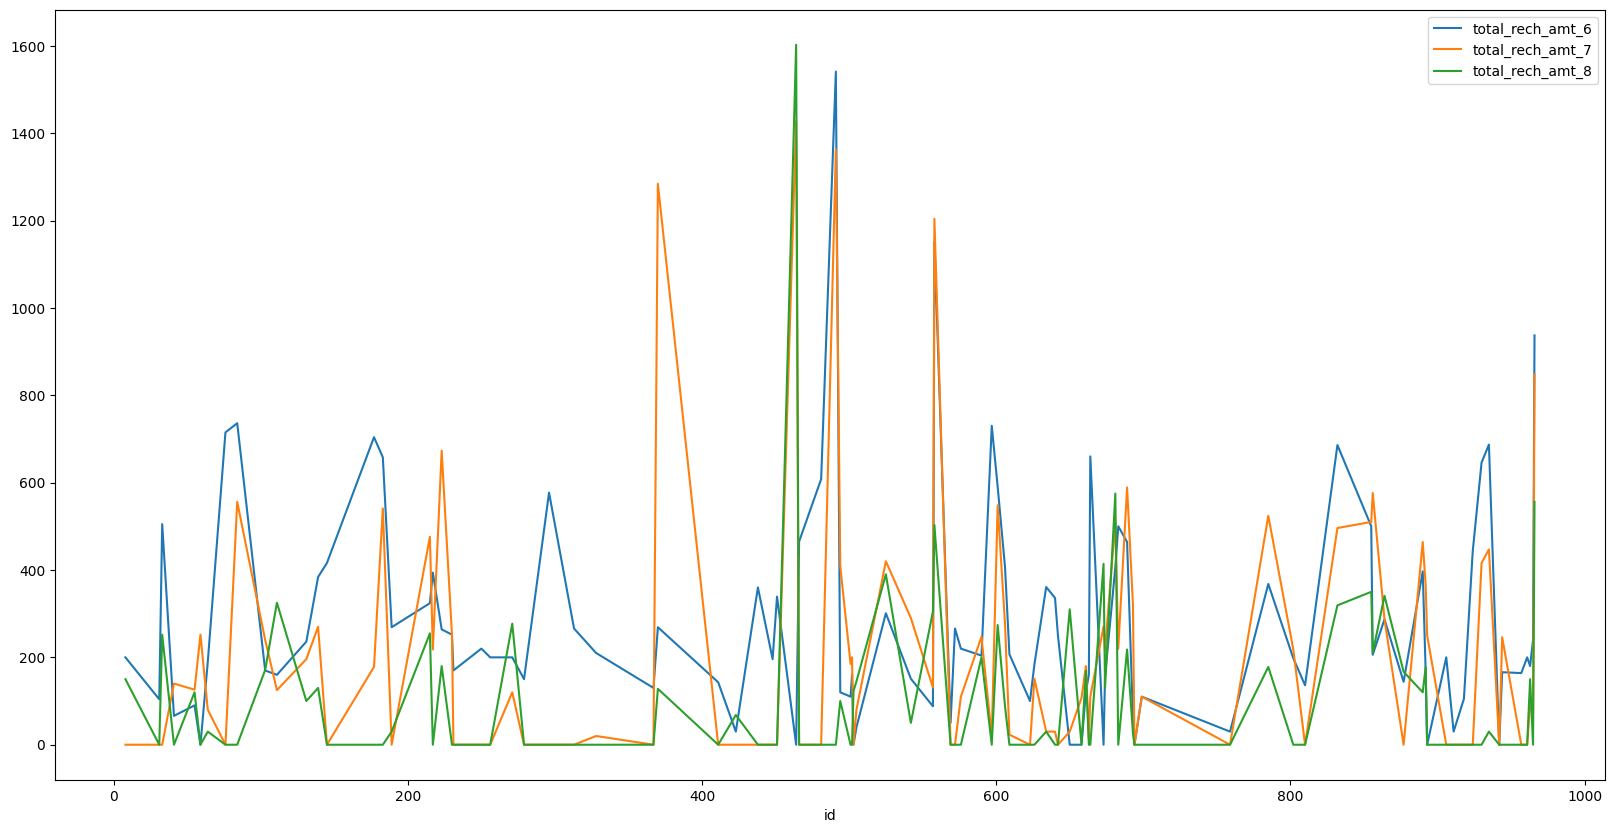

In [ ]:
# Verify the total recharge 
rech_amt = ["total_rech_amt_6",	"total_rech_amt_7",	"total_rech_amt_8"]
plt.figure(figsize=(20,10))
churned_data[rech_amt][:100].plot(figsize=(20,10))

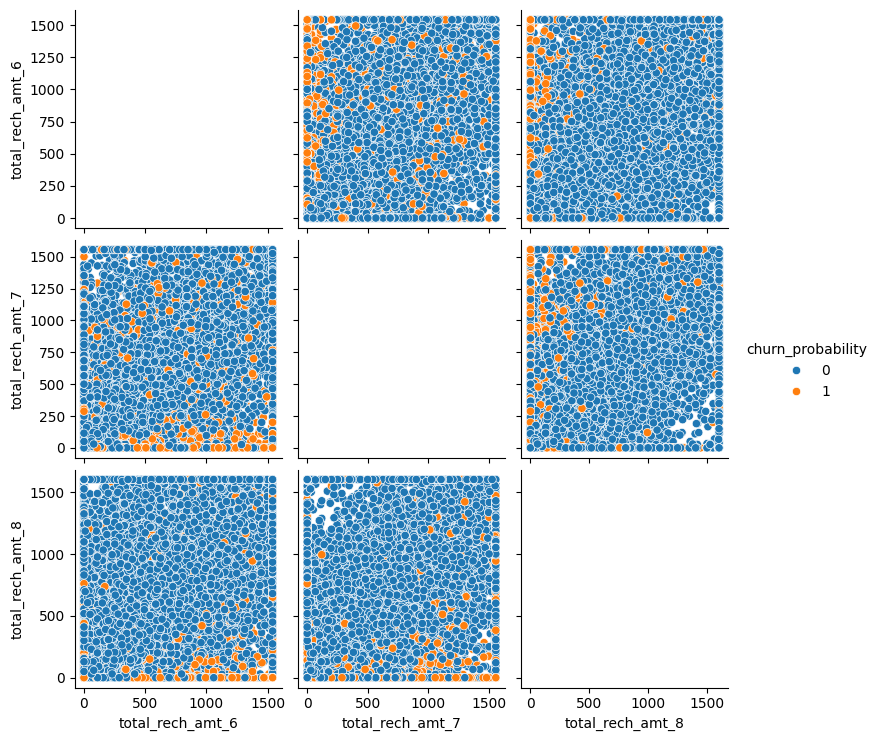

In [ ]:
# Pairplot to check the pattern for the recharge vs churn
sns.pairplot(data=data_tel_details_1[["total_rech_amt_6","total_rech_amt_7","total_rech_amt_8","churn_probability"]],hue='churn_probability',diag_kind='None')
plt.show()

In [ ]:
data_tel_details_1.shape

(69999, 23)

# 4. Data Preparation & Preprocessing

In [ ]:
# Dividing the target column
X = data_tel_details_1[data_tel_details_1.columns.difference(['churn_probability'])]
y = data_tel_details_1["churn_probability"]

In [ ]:
X.shape

(69999, 22)

In [ ]:
y.head()

id
0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: int64

### Splitting test and train data

In [ ]:
# Splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 22), (21000, 22), (48999,), (21000,))

In [ ]:
# Checking the value count for churned data in training dataset
y_train.value_counts()

0    43913
1     5086
Name: churn_probability, dtype: int64

In [ ]:
# Checking the value count for churned data in test dataset
y_test.value_counts()

0    18954
1     2046
Name: churn_probability, dtype: int64

### Feature scaling

In [ ]:
# Using standard scaler to scale the variables
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)

<Axes: >

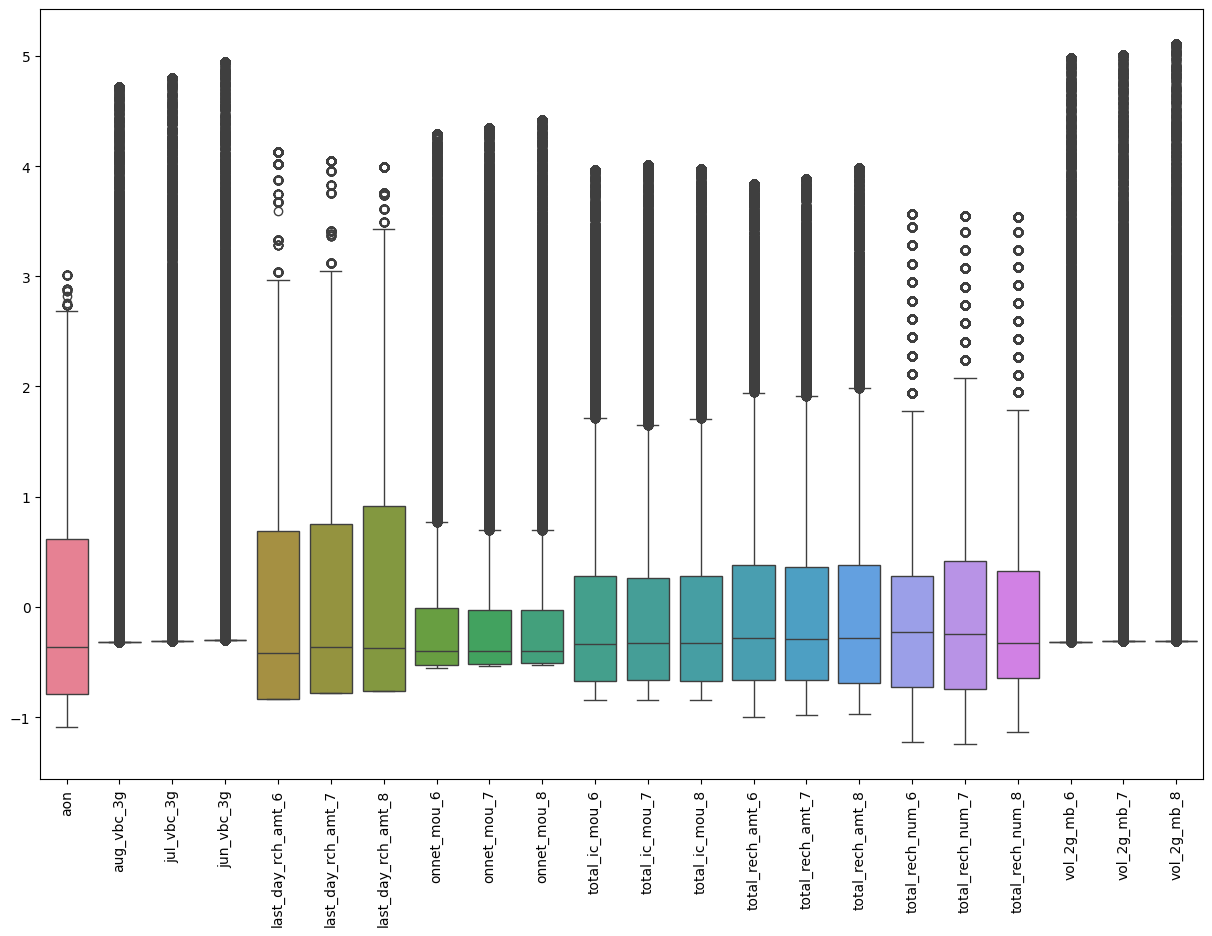

In [ ]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns=data_tel_details_1.columns.difference(['churn_probability'])))

# 5. Feature engineering using PCA

<BarContainer object of 22 artists>

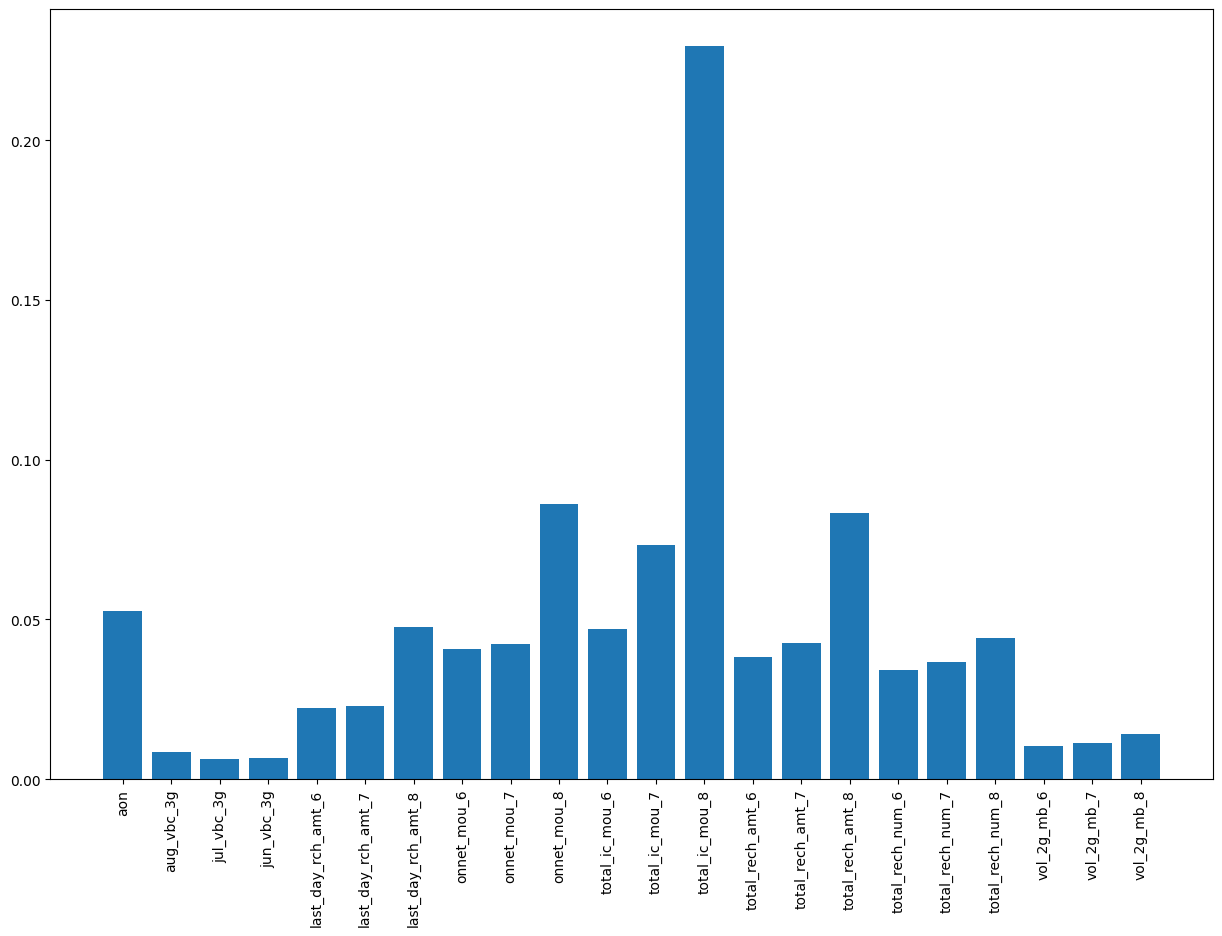

In [ ]:
# Using random forest classifier to do feature engineering
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
feature_importances = pd.DataFrame({'col':data_tel_details_1.columns.difference(['churn_probability']), 'importance':rf.feature_importances_})
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])

In [ ]:
# Initiating PCA object and transform the training set
pca = PCA()
pca_components = pca.fit_transform(X_train)

In [ ]:
# Checking the PCA components
pca.components_

array([[ 9.95269190e-01,  4.71097047e-03,  3.73410786e-03,
         3.31767241e-03,  1.15993635e-02,  1.01567053e-02,
         1.59552118e-02, -5.70446492e-03, -6.69803075e-03,
        -5.85585189e-03,  5.06595418e-02,  5.06072291e-02,
         5.03856384e-02,  1.59167794e-02,  1.77688668e-02,
         2.17711647e-02, -6.55338431e-04, -7.87335912e-04,
        -8.95609148e-04, -5.33324892e-03, -4.71450379e-03,
        -5.13340352e-03],
       [-5.37708394e-02,  7.94654293e-02,  7.77392764e-02,
         6.60842597e-02,  4.52074166e-02,  5.14864714e-02,
         5.01228263e-02,  2.21414944e-01,  2.48807489e-01,
         2.30651808e-01,  1.77832881e-01,  1.98018506e-01,
         1.90003130e-01,  4.65792852e-01,  5.01993423e-01,
         4.81241063e-01,  5.15285043e-03,  5.25603452e-03,
         4.69836566e-03,  2.24596366e-02,  2.26086851e-02,
         2.15481427e-02],
       [-7.57822872e-02,  1.12339697e-01,  1.12772779e-01,
         1.01148738e-01,  7.38560929e-03,  5.60417058e-03,
    

In [ ]:
pca.explained_variance_ratio_

array([5.53285810e-01, 1.85434207e-01, 6.38665357e-02, 4.84238708e-02,
       3.48598042e-02, 2.78294494e-02, 2.04096844e-02, 1.97900660e-02,
       7.19578271e-03, 6.82007901e-03, 5.45187221e-03, 4.65609485e-03,
       4.40669401e-03, 3.84565154e-03, 3.69578795e-03, 3.47327159e-03,
       3.00491783e-03, 1.90482612e-03, 1.61323041e-03, 2.35939439e-05,
       5.32445440e-06, 3.44609022e-06])

In [ ]:
# Checking the cumulative sum of the variance
cumulative_pca = np.cumsum(pca.explained_variance_ratio_)

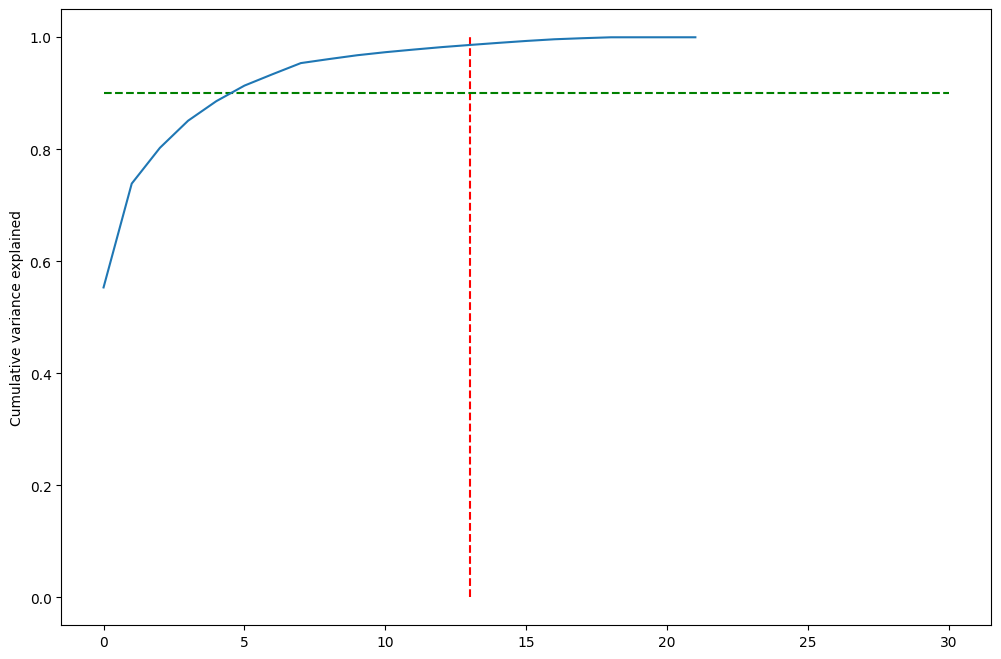

In [ ]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=13, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(cumulative_pca)
plt.ylabel("Cumulative variance explained")
plt.show()

In [ ]:
# Checking the variance and fitting the components
pca_by_variance=PCA(0.95)
pca_components_df = pca_by_variance.fit_transform(X_train)
pca_components_df.shape

(48999, 8)

In [ ]:
X_test_pca = pca_by_variance.transform(X_test)

# 6. Model building

In [ ]:
# Function to check the confusion matrix and accuracy scores
def score(data_x,data_y,model):
    preds = model.predict(data_x)
    print("Confusion Matrix : ")
    print(confusion_matrix(data_y,preds))
    print("Accuracy score : ")
    print(accuracy_score(data_y,preds))

def print_metrics(data_y,preds):
    print("Confusion Matrix : ")
    print(confusion_matrix(data_y,preds))
    print("Accuracy score : ")
    print(accuracy_score(data_y,preds))
    print("Balanced Accuracy")
    print(balanced_accuracy_score(data_y,preds))

In [ ]:
grad_boost = GradientBoostingClassifier( random_state=0).fit(X_train, y_train)

LR_pipe = Pipeline([("scale",StandardScaler()),("model",LogisticRegression())])
PCA_pipe = Pipeline([("scale",StandardScaler()),("reduce",PCA(0.9)),("model",LogisticRegression())])
DT_pipe = Pipeline([("scale",StandardScaler()),("model",DecisionTreeClassifier())])
RF_pipe = Pipeline([("scale",StandardScaler()),("model",RandomForestClassifier())])
XG_pipe = Pipeline([("scale",StandardScaler()),("model",grad_boost)])
XG_PCA_pipe = Pipeline([("scale",StandardScaler()),("reduce",PCA()),("model",GradientBoostingClassifier(random_state=0))])
SVC_pipe = Pipeline([("scale",StandardScaler()),("reduce",PCA()),("model",SVC())])
LGBM_pipe = Pipeline([("scale",StandardScaler()),("reduce",PCA()),("model",lgb.LGBMClassifier())])

### Logistic Regression

In [ ]:
print("LR Pipe")
LR_pipe.fit(X_train,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,LR_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,LR_pipe.predict(X_test))

LR Pipe
**********
Training Data
Confusion Matrix : 
[[43438   475]
 [ 3984  1102]]
Accuracy score : 
0.9089981428192412
Balanced Accuracy
0.6029281891063354
**********
Test data
Confusion Matrix : 
[[18753   201]
 [ 1625   421]]
Accuracy score : 
0.913047619047619
Balanced Accuracy
0.5975813646064542


#### Observation : 
- Accuracy on training data is 90%
- Accuracy on test data is 91%

In [ ]:
print("PCA Pipe")
PCA_pipe.fit(X_train,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,PCA_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,PCA_pipe.predict(X_test))

PCA Pipe
**********
Training Data
Confusion Matrix : 
[[43507   406]
 [ 4350   736]]
Accuracy score : 
0.9029367946284618
Balanced Accuracy
0.5677327087926393
**********
Test data
Confusion Matrix : 
[[18792   162]
 [ 1773   273]]
Accuracy score : 
0.9078571428571428
Balanced Accuracy
0.5624420382484898


#### Observation : 
- Accuracy on training data is 90%
- Accuracy on test data is 90%

### Decision tree

In [ ]:
print("DT Pipe")
DT_pipe.fit(X_train,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,DT_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,DT_pipe.predict(X_test))

DT Pipe
**********
Training Data
Confusion Matrix : 
[[43913     0]
 [    0  5086]]
Accuracy score : 
1.0
Balanced Accuracy
1.0
**********
Test data
Confusion Matrix : 
[[17832  1122]
 [  990  1056]]
Accuracy score : 
0.8994285714285715
Balanced Accuracy
0.7284665420866138


#### Observation : 
- Accuracy on training data is 100%
- Accuracy on test data is 89%

### Random forest classifier

In [ ]:
print("RF Pipe")
RF_pipe.fit(X_train_scaled,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,RF_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,RF_pipe.predict(X_test))

RF Pipe
**********
Training Data
Confusion Matrix : 
[[43913     0]
 [ 5086     0]]
Accuracy score : 
0.8962019633053736
Balanced Accuracy
0.5
**********
Test data
Confusion Matrix : 
[[18954     0]
 [ 2046     0]]
Accuracy score : 
0.9025714285714286
Balanced Accuracy
0.5


#### Observation : 
- Accuracy on training data is 89%
- Accuracy on test data is 90%

### Gradient boosting

In [ ]:
print("XG Pipe")
XG_pipe.fit(X_train_scaled,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,XG_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,XG_pipe.predict(X_test))

XG Pipe
**********
Training Data
Confusion Matrix : 
[[43913     0]
 [ 5086     0]]
Accuracy score : 
0.8962019633053736
Balanced Accuracy
0.5
**********
Test data
Confusion Matrix : 
[[18954     0]
 [ 2046     0]]
Accuracy score : 
0.9025714285714286
Balanced Accuracy
0.5


#### Observation : 
- Accuracy on training data is 89%
- Accuracy on test data is 90%

In [ ]:
print("XG PCA Pipe")
XG_PCA_pipe.fit(X_train_scaled,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,XG_PCA_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,XG_PCA_pipe.predict(X_test))

XG PCA Pipe
**********
Training Data
Confusion Matrix : 
[[ 2024 41889]
 [  115  4971]]
Accuracy score : 
0.14275801546970346
Balanced Accuracy
0.5117400227395249
**********
Test data
Confusion Matrix : 
[[  933 18021]
 [   42  2004]]
Accuracy score : 
0.13985714285714285
Balanced Accuracy
0.5143482894378952


#### Observation : 
- Accuracy on training data is 14%
- Accuracy on test data is 13%

### Support Vector Classfier

In [ ]:
print("SVC Pipe")
SVC_pipe.fit(X_train_scaled,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,SVC_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,SVC_pipe.predict(X_test))

SVC Pipe
**********
Training Data
Confusion Matrix : 
[[43913     0]
 [ 5086     0]]
Accuracy score : 
0.8962019633053736
Balanced Accuracy
0.5
**********
Test data
Confusion Matrix : 
[[18954     0]
 [ 2046     0]]
Accuracy score : 
0.9025714285714286
Balanced Accuracy
0.5


#### Observation : 
- Accuracy on training data is 89%
- Accuracy on test data is 90%

### Light BGM

In [ ]:
print("LGBM Pipe")
LGBM_pipe.fit(X_train_scaled,y_train)
print('*'*10)
print("Training Data")
print_metrics(y_train,LGBM_pipe.predict(X_train))
print('*'*10)
print("Test data")
print_metrics(y_test,LGBM_pipe.predict(X_test))

LGBM Pipe
[LightGBM] [Info] Number of positive: 5086, number of negative: 43913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 48999, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103798 -> initscore=-2.155719
[LightGBM] [Info] Start training from score -2.155719
**********
Training Data
Confusion Matrix : 
[[40880  3033]
 [ 3863  1223]]
Accuracy score : 
0.859262433927223
Balanced Accuracy
0.5856978168295606
**********
Test data
Confusion Matrix : 
[[17633  1321]
 [ 1512   534]]
Accuracy score : 
0.8650952380952381
Balanced Accuracy
0.5956510081360739


#### Observation : 
- Accuracy on training data is 85%
- Accuracy on test data is 86%

In [ ]:
def grid_search(pipe,hyper_params,n_splits,X_train,y_train):
  # creating a KFold object with 5 splits
  folds = KFold(n_splits = n_splits, shuffle = True, random_state = 100)


  model_cv = GridSearchCV(estimator = pipe,
                          param_grid = hyper_params,
                          scoring= 'accuracy',
                          cv = folds,
                          verbose = 3,
                          return_train_score=True)

  # fit the model
  model_cv.fit(X_train, y_train)
  return model_cv

In [ ]:
Base_pipe = Pipeline([("scale",StandardScaler()),("reduce",None),("model",None)])

hyper_params = [{
    "model":[GradientBoostingClassifier(random_state=0)],
    "reduce":[PCA()],
    "reduce__n_components": [5, 10,15],
    "model__n_estimators": [100,500,1000]
},
{
    "model":[LogisticRegression()],
    "reduce":[PCA()],
    "reduce__n_components": [5, 10,15]
},
{
    "model":[GradientBoostingClassifier(random_state=0)],
    "model__n_estimators": [100,500,1000]
},
{
    "model":[LogisticRegression()]
},
{
    "model":[SVC()],
    "reduce":[PCA()],
    "reduce__n_components": [5, 10,15]
},
{
    "model":[lgb.LGBMClassifier()],
    "reduce":[PCA()],
    "reduce__n_components": [5, 10,15],
    "model__n_estimators": [100,500,1000]
}
                ]

model_cv_estimator = grid_search(Base_pipe,hyper_params,5,X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END model=GradientBoostingClassifier(random_state=0), model__n_estimators=100, reduce=PCA(), reduce__n_components=5;, score=(train=0.904, test=0.902) total time=  10.6s
[CV 2/5] END model=GradientBoostingClassifier(random_state=0), model__n_estimators=100, reduce=PCA(), reduce__n_components=5;, score=(train=0.904, test=0.901) total time=  10.7s
[CV 3/5] END model=GradientBoostingClassifier(random_state=0), model__n_estimators=100, reduce=PCA(), reduce__n_components=5;, score=(train=0.904, test=0.902) total time=  10.8s
[CV 4/5] END model=GradientBoostingClassifier(random_state=0), model__n_estimators=100, reduce=PCA(), reduce__n_components=5;, score=(train=0.904, test=0.899) total time=  10.7s
[CV 5/5] END model=GradientBoostingClassifier(random_state=0), model__n_estimators=100, reduce=PCA(), reduce__n_components=5;, score=(train=0.903, test=0.906) total time=  10.9s
[CV 1/5] END model=GradientBoostingClassifier(ra

In [ ]:
# model_cv.best_params_
model_cv_estimator.best_params_

{'model': GradientBoostingClassifier(random_state=0),
 'model__n_estimators': 100}

#### Observation : 
- As per the grid search the best model is Gradient boosting classifier

In [ ]:
print(X_test.shape)
print_metrics(y_test,model_cv_estimator.predict(X_test))

(21000, 22)
Confusion Matrix : 
[[18541   413]
 [  760  1286]]
Accuracy score : 
0.9441428571428572
Balanced Accuracy
0.8033769518237858


Handling class imbalance

In [ ]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', y_train.value_counts())
print('Resample dataset shape', y_smote.value_counts())

Original dataset shape 0    43913
1     5086
Name: churn_probability, dtype: int64
Resample dataset shape 0    43913
1    43913
Name: churn_probability, dtype: int64


In [ ]:
CV_Searched_pipe = Pipeline([("scale",StandardScaler()),("model",GradientBoostingClassifier(random_state=0,n_estimators=100))])
CV_Searched_pipe.fit(x_smote,y_smote)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

In [ ]:
print("CV Searched SMOTE Pipe")
print_metrics(y_test,CV_Searched_pipe.predict(X_test))

CV Searched SMOTE Pipe
Confusion Matrix : 
[[17868  1086]
 [  556  1490]]
Accuracy score : 
0.9218095238095239
Balanced Accuracy
0.8354768157635541


In [ ]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', y_ros.value_counts())

Original dataset shape 0    62867
1     7132
Name: churn_probability, dtype: int64
Resample dataset shape 0    43913
1    43913
Name: churn_probability, dtype: int64


In [ ]:
CV_Searched_pipe_ros = Pipeline([("scale",StandardScaler()),("model",GradientBoostingClassifier(random_state=0,n_estimators=100))])
CV_Searched_pipe_ros.fit(x_ros,y_ros)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

In [ ]:
print("CV Searched ROS Pipe")
print_metrics(y_test,CV_Searched_pipe_ros.predict(X_test))

CV Searched ROS Pipe
Confusion Matrix : 
[[17163  1791]
 [  389  1657]]
Accuracy score : 
0.8961904761904762
Balanced Accuracy
0.8576904974754437


In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
Bagging_pipe = Pipeline([("scale",StandardScaler()),("model",classifier)])
Bagging_pipe.fit(X_train, y_train)
preds = Bagging_pipe.predict(X_test)
print_metrics(y_test,preds)

Confusion Matrix : 
[[18568   386]
 [  924  1122]]
Accuracy score : 
0.9376190476190476
Balanced Accuracy
0.7640110011675125


# 7. Predicting unseen date 

In [ ]:
unseen.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   65.330   64.445        31.78        20.23        23.11         60.16   
1  515.568  360.868        75.51        41.21        19.84        474.34   
2  434.884  746.239         7.54         7.86         8.40         16.98   
3  171.390   24.400         5.31         2.16         0.00         40.04   
4  406.289  413.329       450.93       609.03       700.68         60.94   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         32.16         34.83           0.00           0.00           0.00   
1        621.84        394.94           0.00           0.00           0.00   
2         45.81         45.04          22.81         103.38          26.08   
3        205.01         24.01           0.00           0.00           0.00   
4         23.84         74.16           0.00           0.00           0.00   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00           0.00           0.00             24.88   
1           0.00           0.00           0.00             75.51   
2          24.53          53.68          54.44              0.00   
3           0.00           0.00           0.00              5.31   
4           0.00           0.00           0.00              0.45   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             20.23             21.06             18.13             10.89   
1             41.21             19.84            473.61            598.08   
2              0.00              0.00              0.00              0.00   
3              0.00              0.00              2.94             98.61   
4              0.78             14.56              2.39              2.66   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              8.36              0.00             13.58              0.00   
1            377.26              0.73              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             20.51              0.00              0.00              2.35   
4             10.94              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0              0.00              0.03         43.01   
1               0.0              0.00              0.00        549.86   
2               0.0              0.00              0.00          0.00   
3               0.0              6.18              0.00          8.26   
4               0.0              0.00              0.00          2.84   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         44.71         29.43              6.90              0.00   
1        639.29        397.11              0.00              0.00   
2          0.00          0.00              0.00              0.00   
3         98.61         22.86              0.00              2.16   
4          3.44         25.51            450.48            608.24   

 

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
unseen[impute_list] = imp.fit_transform(unseen[impute_list])

In [ ]:
X_train.columns

Index(['aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8'],
      dtype='object')

In [ ]:
submission_data = unseen[X_train.columns]
submission_data['id'] = unseen['id']
submission_data.set_index('id')
submission_data.shape

(30000, 23)

In [ ]:
unseen['churn_probability'] = Bagging_pipe.predict(submission_data[X_train.columns])
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  1
3  70002                  0
4  70003                  0

## Creating submission file

In [ ]:
output.to_csv('/content/submission_bagging_classifier.csv',index=False)